Many have proposed various methods for declaring what FBS College Football conference is "The Strongest Conference". Some could cite the number of National Championships, Bowl games, highest ratings, game attendance, or even revenue.

This analysis seeks to see the trends (season-to-season for the last 100 years) of conference strength defined as the non-conference win percentage for that conference. This win percentage is calculated by taking all the non-conference games across all teams for a conference, finding the win/loss/tie outcome (encoded 1/0/0.5 respectively), and then taking the average of the outcomes. If a conference is strong, then it should win their non-conference games. If they are weak, then they should loose their non-conference games. Furthermore, this method relies less on opinion of polls or limitation of stadium attendance.

# Methodology Notes:
   1. I pulled data from 1923 and on, but could have gone back further.
   2. Vacated wins are not vacated in this analysis.
   3. Ties counted as a half-win.
   4. I considered defunct conferences for the calculation of non-conference wins, but did not show the defunct conferences in the graphics.
   5. I tried to capture when conferences re-branded vs. collapsed. For example, when the PAC 10 became the PAC 12, I considered that the same conference (SEC did not re-brand when they added schools!). However, the exact ones to choose are up for debate.
   6. This approach follows the brand of a conference over time.
   
# Interesting findings:
   1. Under these metrics, there is weight to the argument that the SEC is the best conference in college football. Their non-conference win percentage was the highest in average and median over their existence. The variance of the win percentage was small as well.
   2. The American Athletic Conference performs more like a Power 5 conference, although their success has fallen in recent yeas.
   3. The Sun Belt, appears to be a rising star withing the Group of 5.
   3. Today's Power 5 Conferences have been steadily growing in strength starting in the 1950's-70's (depending on the conference), but seem to have plateaued over the last 20 years.
   5. Today's Power 5 Conferences are playing each other proportionally more than in previous years.
   4. Independents have been holding at about a 50% win-rate for the last 100 years. This differs from the patterns from the other conferences.

# Report overview:
This report attempts to provide detail into what conferences tend to play each other and how well they have done. This is accomplished by analyzing several areas:
1. Data Preparation (for remainder of sections)
2. Exploratory Data Analysis
3. How conferences have performed against Power 5 and Group of 5 in the last 10 years
4. The non-conference win-rate trend over time
5. General conference scheduling and win-rates

# Part 1 - Prepare Environment and Get Data
## 1.1 - Import Packages

In [1]:
# import packages
from scipy.interpolate import UnivariateSpline
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import cfbd
import os

## 1.2 Pull and Save Data

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# define variables

pull_data = False
fileName = "100_Year_Football_Data_new.csv"
year_end = 2025

In [4]:
# Pull data from website

if pull_data:
    api_key = '[see instruction on https://collegefootballdata.com/ under the API tab]'
    
    configuration = cfbd.Configuration()
    configuration.api_key['Authorization'] = api_key
    configuration.api_key_prefix['Authorization'] = 'Bearer'
    
    api_instance = cfbd.GamesApi(cfbd.ApiClient(configuration))
    
    all_games = []
    
    for season in range(1923,year_end+1):
        print(season)
        games = api_instance.get_games(year=season)
        all_games.extend(games)
    
    
    games_as_list = [{k:v if k not in ['away_line_scores', 'home_line_scores'] else None for k,v in all_games[0].to_dict().items()}]
    games_df = pd.DataFrame({k:[v] for k,v in all_games[0].to_dict().items()})
    for game in range(1, len(all_games)):
        
        games_as_list.extend([{k:v if k not in ['away_line_scores', 'home_line_scores'] else None for k,v in all_games[game].to_dict().items()}])
    
    games_df = pd.DataFrame.from_records(games_as_list)
    games_df.to_csv(fileName, index = False)


# Part 2 - Do Some Exploratory Data Analysis (EDA)

Findings:
Since the number of FBS teams is rising back to levels just before Division 1 AA (today called FCS), it could be possible that we will see a potential split again soon.

In [5]:
# pull data localy and clean data

games_df = pd.read_csv(fileName)


In [6]:
games_df.columns

Index(['id', 'season', 'week', 'seasonType', 'startDate', 'startTimeTBD',
       'completed', 'neutralSite', 'conferenceGame', 'homeId', 'homeTeam',
       'homePoints', 'homeLineScores', 'awayId', 'awayTeam', 'awayConference',
       'awayClassification', 'awayPoints', 'awayLineScores', 'highlights',
       'attendance', 'venueId', 'venue', 'homeConference',
       'homeClassification', 'homePostgameWinProbability', 'homePregameElo',
       'homePostgameElo', 'awayPostgameWinProbability', 'awayPregameElo',
       'awayPostgameElo', 'excitementIndex', 'notes'],
      dtype='object')

In [7]:
games_df.head()

,id,season,week,seasonType,startDate,startTimeTBD,completed,neutralSite,conferenceGame,homeId,...,homeConference,homeClassification,homePostgameWinProbability,homePregameElo,homePostgameElo,awayPostgameWinProbability,awayPregameElo,awayPostgameElo,excitementIndex,notes
0,12763,1923,1,regular,1923-09-22 00:00:00+00:00,False,True,False,False,2105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12763,1923,1,regular,1923-09-22 00:00:00+00:00,False,True,False,False,2105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12767,1923,1,regular,1923-09-22 00:00:00+00:00,False,True,False,False,245,...,Southwest,fbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12766,1923,1,regular,1923-09-22 00:00:00+00:00,False,True,False,False,2535,...,FBS Independents,fbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12765,1923,1,regular,1923-09-22 00:00:00+00:00,False,True,False,False,2166,...,FBS Independents,fbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
games_df.tail()

,id,season,week,seasonType,startDate,startTimeTBD,completed,neutralSite,conferenceGame,homeId,...,homeConference,homeClassification,homePostgameWinProbability,homePregameElo,homePostgameElo,awayPostgameWinProbability,awayPregameElo,awayPostgameElo,excitementIndex,notes
92400,401741208,2024,1,postseason,2025-01-06 01:00:00+00:00,False,True,True,False,3071,...,CCIW,iii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Division III Championship
92401,401680057,2024,1,postseason,2025-01-07 00:00:00+00:00,False,True,True,False,147,...,Big Sky,fcs,0.247970,NaN,NaN,0.752030,NaN,NaN,4.820656,FCS Championship
92402,401677189,2024,1,postseason,2025-01-10 00:30:00+00:00,False,True,True,False,213,...,Big Ten,fbs,0.340890,2063.0,2063.0,0.659110,2173.0,2173.0,8.328996,College Football Playoff Semifinal at the Capi...
92403,401677191,2024,1,postseason,2025-01-11 00:30:00+00:00,False,True,True,False,251,...,SEC,fbs,0.013624,2056.0,2042.0,0.986376,2182.0,2196.0,6.155203,College Football Playoff Semifinal at the Good...
92404,401677192,2024,1,postseason,2025-01-21 00:30:00+00:00,False,True,True,False,87,...,FBS Independents,fbs,0.034767,2169.0,2154.0,0.965233,2196.0,2211.0,2.819260,College Football Playoff National Championship...


In [9]:
len(games_df)

92405

## 2.1 - How many teams have been playing FBS Football over time?

In [10]:
home_df = games_df[['homeId', 'homeClassification', 'season']].rename({'homeId': 'id', 'homeClassification': 'division'},axis = 'columns')
away_df = games_df[['awayId', 'awayClassification', 'season']].rename({'awayId': 'id', 'awayClassification': 'division'},axis = 'columns')

teams_df= pd.concat([home_df,away_df]).drop_duplicates()
teams_df['division'] = teams_df['division'].fillna("unknown")
teams_df = teams_df[teams_df['division'] == 'fbs']

Text(0.5, 1.0, 'Number of FBS Teams Over Time')

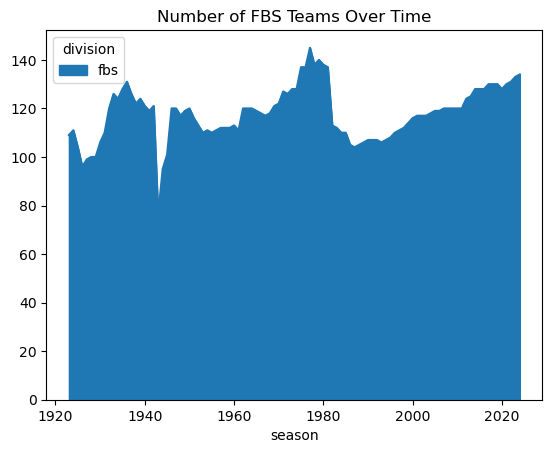

In [11]:
counts = pd.pivot_table(teams_df, values='id', index='season', columns='division',
               aggfunc='count')
counts.plot.area()
plt.title("Number of FBS Teams Over Time")

#### Key Takeaway
1. The valley in the 1940's could likely be due to WW2 
2. The valley in the 1980's could be the introduction of Division 1 AA (today called FCS) 
3. Since the number of FBS teams is rising back to levels just before Division 1 AA, it could be possible that we will see a potential split again soon.

## 2.2 - How many Independents have are there over time?

In [12]:
home_df = games_df[['homeId', 'homeConference', 'season']].rename({'homeId': 'id', 'homeConference': 'conference'},axis = 'columns')
away_df = games_df[['awayId', 'awayConference', 'season']].rename({'awayId': 'id', 'awayConference': 'conference'},axis = 'columns')

teams_df= pd.concat([home_df,away_df]).drop_duplicates()
teams_df['conference'] = teams_df['conference'].fillna("unknown")
teams_df = teams_df[teams_df['conference'] == 'FBS Independents']

Text(0.5, 1.0, 'Number of FBS Independent Teams Over Time')

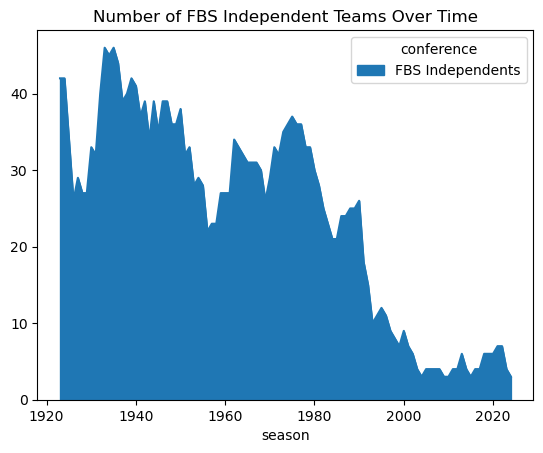

In [13]:
counts = pd.pivot_table(teams_df, values='id', index='season', columns='conference',
               aggfunc='count')
counts.plot.area()
plt.title("Number of FBS Independent Teams Over Time")

#### Key Takeaway
1. Since the 1980's when the Division 1 AA (today called FCS) was introduced, the number of independents has fallen sharply.
2. This coincides with Group of 5 conferences begining.

## 2.3 - How many completed FBS games were played by season?
Filter for FBS vs. FBS only and Completed Games

In [14]:
fbs_only_df = games_df[(games_df['homeClassification']=='fbs')&
                       (games_df['awayClassification']=='fbs')&
                       (games_df['completed']==True)]


In [15]:
fbs_only_df.head()

,id,season,week,seasonType,startDate,startTimeTBD,completed,neutralSite,conferenceGame,homeId,...,homeConference,homeClassification,homePostgameWinProbability,homePregameElo,homePostgameElo,awayPostgameWinProbability,awayPregameElo,awayPostgameElo,excitementIndex,notes
52,12777,1923,2,regular,1923-09-29 00:00:00+00:00,False,True,False,True,2,...,Southern,fbs,NaN,1821.0,1809.0,NaN,1539.0,1551.0,NaN,NaN
53,12776,1923,2,regular,1923-09-29 00:00:00+00:00,False,True,False,False,349,...,FBS Independents,fbs,NaN,1575.0,1713.0,NaN,1689.0,1551.0,NaN,NaN
55,12806,1923,2,regular,1923-09-29 00:00:00+00:00,False,True,False,False,153,...,Southern,fbs,NaN,1613.0,1626.0,NaN,1213.0,1200.0,NaN,NaN
56,12804,1923,2,regular,1923-09-29 00:00:00+00:00,False,True,False,True,2426,...,FBS Independents,fbs,NaN,1689.0,1745.0,NaN,1513.0,1457.0,NaN,NaN
57,12797,1923,2,regular,1923-09-29 00:00:00+00:00,False,True,False,False,2294,...,Western,fbs,NaN,1730.0,1750.0,NaN,1459.0,1439.0,NaN,NaN


In [16]:
fbs_only_df.tail()

,id,season,week,seasonType,startDate,startTimeTBD,completed,neutralSite,conferenceGame,homeId,...,homeConference,homeClassification,homePostgameWinProbability,homePregameElo,homePostgameElo,awayPostgameWinProbability,awayPregameElo,awayPostgameElo,excitementIndex,notes
92398,401677107,2024,1,postseason,2025-01-04 00:30:00+00:00,False,True,True,False,259,...,ACC,fbs,0.005566,1675.0,1647.0,0.994434,1646.0,1674.0,3.722019,Duke's Mayo Bowl
92399,401677108,2024,1,postseason,2025-01-04 16:00:00+00:00,False,True,True,False,2335,...,Conference USA,fbs,0.005421,1573.0,1503.0,0.994579,1304.0,1374.0,3.788498,Bahamas Bowl Presented by Atlantis Resorts
92402,401677189,2024,1,postseason,2025-01-10 00:30:00+00:00,False,True,True,False,213,...,Big Ten,fbs,0.340890,2063.0,2063.0,0.659110,2173.0,2173.0,8.328996,College Football Playoff Semifinal at the Capi...
92403,401677191,2024,1,postseason,2025-01-11 00:30:00+00:00,False,True,True,False,251,...,SEC,fbs,0.013624,2056.0,2042.0,0.986376,2182.0,2196.0,6.155203,College Football Playoff Semifinal at the Good...
92404,401677192,2024,1,postseason,2025-01-21 00:30:00+00:00,False,True,True,False,87,...,FBS Independents,fbs,0.034767,2169.0,2154.0,0.965233,2196.0,2211.0,2.819260,College Football Playoff National Championship...


In [17]:
len(fbs_only_df)

58410

Text(0.5, 1.0, 'Number of Completed FBS Games Over Time')

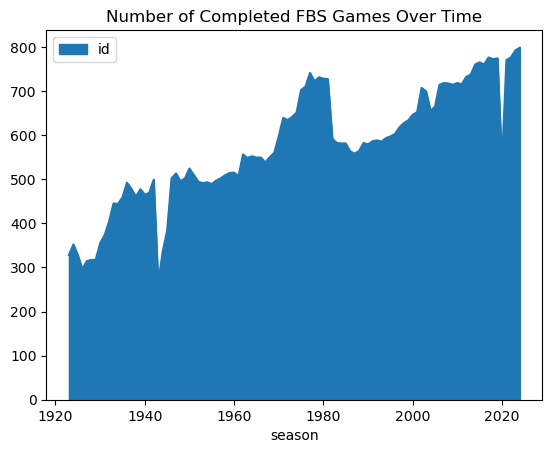

In [18]:
games_per_season_count = fbs_only_df.groupby('season')['id'].nunique().reset_index()
games_per_season_count.plot.area('season', 'id')
plt.title("Number of Completed FBS Games Over Time")

#### Key Takeaways
1. The valley in the 1940's could likely be due to WW2
2. The valley in the 1980's could be the introduction of Division 1 AA (today called FCS)
3. The valley in the 2020 could be the COVID-19 Pandemic restrictions

# Part 3 - Compare Conferences with Each Other


Q1: Over the last 10 years, what conferences have done well against Power 5 and Group of 5?

Findings:
1. There appears to be a strong positive correlation between winning against Power 5 opponents and winning against Group of 5 opponents.
2. There may be 3 clusters of Conferences instead of just Power 5 and Group of 5.
4. Compared to unbalance schedules, the Power 5 conferences are more compact in their performance.

Q2: How are the Non-Conference Win Percents Trending

Findings:
Power 5:
1. Power 5 Conferences tend to win more non-conference games than lose.
2. SEC has consistently been the best conference
3. ACC has been the worst conference
4. Power 5 Conferences have been trending stronger over time.
Group of 5:
1. The Group of 5 tends to lose more non-conference games than win.
2. Most conferences are relatively new
3. All but the Sun Belt have been generally declining in performance.

Q3: What conferences tend to play each other?

Findings:
1. Power 5 teams have historically played others rather themselves
2. Power 5 teams are increasingly playing each other now.

Q4: Where are the wins and losses coming from?
Findings:

1. Power 5 conferences tend to beat Group of 5 Conferences
2. Within the Power 5, there seems to be 2 strong scheduling relationships:
   * SEC/ACC (~50% of their Power 5 schedule)
     - SEC tends to beat ACC (~65%) more than they beat others Power 5 conferences, but only by a few percentage points. Thus, the scheduling imbalance does not inflate their non-conference win percentage too much.
   * Pac-12/Big-Ten/Big-12 (~50% of their Power 5 schedule)
     - Big Ten seems to be the best by tending to beat Big 12 (~56%) while remaining about even with the Pac 12
3. There is no discernible scheduling relationship at the Group of 5 level
4. American Athletic has performed more like a Power 5 conference than a Group of 5 conference.
5. American Athletic Conference has been at the top of the Group of 5 while Mid American has been at the bottom.
6. However, American Athletic has seen a drop in Group of 5 wins while the Sun Belt has seen an increase within the Group of 5. 

## 3.1 - Prepare data
### 3.1.1 - Fix old conference names to present-day ones

In [19]:

# Set old conference names to the current name 
fbs_only_df.loc[(fbs_only_df['homeConference']=="Pacific") |
                (fbs_only_df['homeConference']=="Pac-8") |
                (fbs_only_df['homeConference']=="Pac-10") |
                (fbs_only_df['homeConference']=="AAWU"), 'homeConference']='Pac-12'

fbs_only_df.loc[(fbs_only_df['awayConference']=="Pacific") |
                (fbs_only_df['awayConference']=="Pac-8") |
                (fbs_only_df['awayConference']=="Pac-10") |
                (fbs_only_df['awayConference']=="AAWU"), 'awayConference']='Pac-12'

fbs_only_df.loc[(fbs_only_df['homeConference']=="PCAA"), 'homeConference']='Big West'
fbs_only_df.loc[(fbs_only_df['awayConference']=="PCAA"), 'awayConference']='Big West'

fbs_only_df.loc[(fbs_only_df['homeConference']=="Western"), 'homeConference']='Big Ten'
fbs_only_df.loc[(fbs_only_df['awayConference']=="Western"), 'awayConference']='Big Ten'

fbs_only_df.loc[(fbs_only_df['homeConference']=="Big East"), 'homeConference']='American Athletic'
fbs_only_df.loc[(fbs_only_df['awayConference']=="Big East"), 'awayConference']='American Athletic'

fbs_only_df.loc[(fbs_only_df['homeConference']=="Big 8") |
                (fbs_only_df['homeConference']=="Big 6") |
                (fbs_only_df['homeConference']=="Missouri Valley") |
                (fbs_only_df['homeConference']=="Big 7"), 'homeConference']='Big 12'

fbs_only_df.loc[(fbs_only_df['awayConference']=="Big 8") |
                (fbs_only_df['awayConference']=="Big 6") |
                (fbs_only_df['awayConference']=="Missouri Valley") |
                (fbs_only_df['awayConference']=="Big 7"), 'awayConference']='Big 12'


### 3.1.2 - Identify the game outcome

In [20]:
fbs_only_df['homeOutcome'] = None
fbs_only_df.loc[(fbs_only_df['homePoints']==fbs_only_df['awayPoints']), 'homeOutcome'] = 'Tie'
fbs_only_df.loc[(fbs_only_df['homePoints']>fbs_only_df['awayPoints']), 'homeOutcome'] = 'Win'
fbs_only_df.loc[(fbs_only_df['homePoints']<fbs_only_df['awayPoints']), 'homeOutcome'] = 'Loss'

fbs_only_df['awayOutcome'] = None
fbs_only_df.loc[(fbs_only_df['homeOutcome']=='Tie'), 'awayOutcome'] = 'Tie'
fbs_only_df.loc[(fbs_only_df['homeOutcome']=='Loss'), 'awayOutcome'] = 'Win'
fbs_only_df.loc[(fbs_only_df['homeOutcome']=='Win'), 'awayOutcome'] = 'Loss'


### 3.1.3 - Filter for non-conference games only

In [21]:

# keep only the out of conference matchups
fbs_only_df['adjusted_in_conference'] = fbs_only_df['homeConference']==fbs_only_df['awayConference']
fbs_non_conference= fbs_only_df[~fbs_only_df['adjusted_in_conference']]


In [22]:
len(fbs_non_conference)

20129

## 3.2 - Over the last 10 years, what conferences have done well against Power 5 and Group of 5?

Findings:
1. There appears to be a strong positive correlation between winning against Power 5 opponents and winning against Group of 5 opponents.
2. There may be 3 clusters of Conferences instead of just Power 5 and Group of 5.
3. The American Athletic Conference performs more like a weak Power 5 than a strong Group of 5 Conference.
4. Compared to unbalance schedules, the Power 5 conferences are more compact in their performance.

### 3.2.1 - Plot a graphic of a conference's performance against Power 5 vs Group of 5.
When looking at a conference there are several factors 

opponent_group     Group of 5   Power 5
conference_source                      
ACC                  0.760870  0.415525
American Athletic    0.658683  0.306878
Big 12               0.774436  0.493243
Big Ten              0.868293  0.530303
Conference USA       0.414747  0.087209
FBS Independents     0.512821  0.469484
Mid-American         0.396226  0.147368
Mountain West        0.552448  0.257576
Pac-12               0.694444  0.462810
SEC                  0.879310  0.579646
Sun Belt             0.504762  0.140940


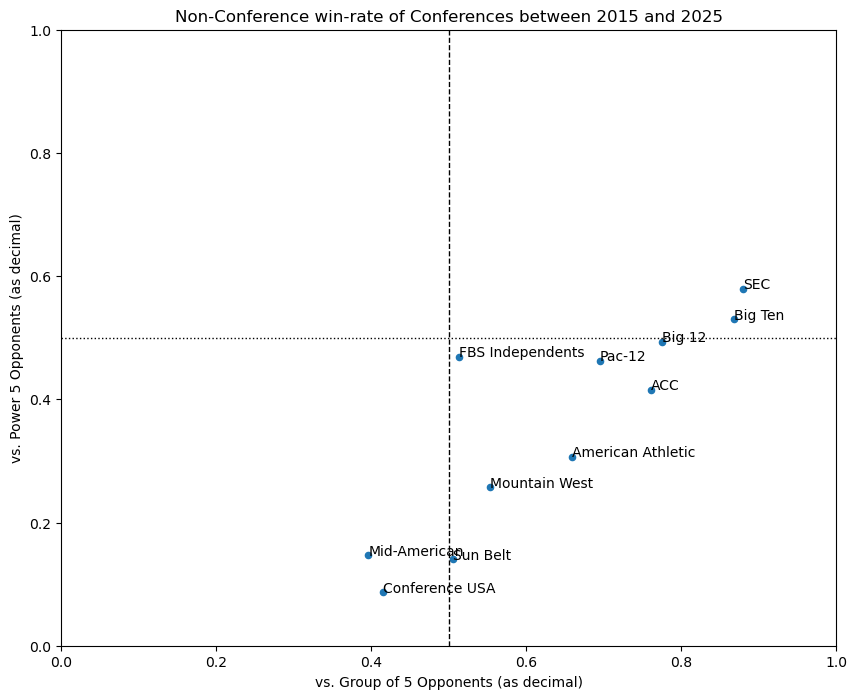

In [158]:
filter_season_year = year_end-10

current_conferences = ['ACC', 'Big Ten', 'Big 12', 'Pac-12', 'SEC','American Athletic', 'Conference USA', 'Mid-American', 'Mountain West', 'Sun Belt', 'FBS Independents']

fbs_non_conference_0 = fbs_non_conference[['season', 'week', 'homeId', 'homeTeam', 'homeConference', 'homeOutcome', 'awayId', 'awayTeam', 'awayConference']]
fbs_non_conference_1 = fbs_non_conference[['season', 'week', 'awayId', 'awayTeam', 'awayConference', 'awayOutcome', 'homeId', 'homeTeam', 'homeConference']]

fbs_non_conference_0.rename({'homeID': 'schoolId_1',
                             'homeTeam': 'team_1',
                             'homeConference': 'conference_source',
                             'awayID': 'schoolId_2',
                             'awayTeam': 'team_2',
                             'awayConference': 'conference_opponent',
                             'homeOutcome': 'win-rate'}, inplace = True, axis = 'columns')

fbs_non_conference_1.rename({'homeID': 'schoolId_2',
                             'homeTeam': 'team_2',
                             'homeConference': 'conference_opponent',
                             'awayID': 'schoolId_1',
                             'awayTeam': 'team_1',
                             'awayConference': 'conference_source',
                             'awayOutcome': 'win-rate'}, inplace = True, axis = 'columns')

fbs_non_conference_by_school_for_overall = pd.concat([fbs_non_conference_0, fbs_non_conference_1])

fbs_non_conference_by_school_for_overall = fbs_non_conference_by_school_for_overall.replace({'win-rate': {'Win': 1, 'Loss':0, 'Tie':0.5}})

combined_conferences = fbs_non_conference_by_school_for_overall[fbs_non_conference_by_school_for_overall['conference_source'].isin(current_conferences) &
                                                                fbs_non_conference_by_school_for_overall['conference_opponent'].isin(current_conferences) &
                                                                (fbs_non_conference_by_school_for_overall['season'] >= filter_season_year)]

conference_group_dict = {'ACC' : 'Power 5', 
                         'Big Ten' : 'Power 5', 
                         'Big 12' : 'Power 5', 
                         'Pac-12' : 'Power 5', 
                         'SEC' : 'Power 5',
                         'American Athletic' : 'Group of 5', 
                         'Conference USA' : 'Group of 5', 
                         'Mid-American' : 'Group of 5', 
                         'Mountain West' : 'Group of 5', 
                         'Sun Belt' : 'Group of 5', 
                         'FBS Independents' : 'FBS Independents'
                        }

combined_conferences['opponent_group'] = combined_conferences['conference_opponent'].map(conference_group_dict).fillna('Defunct')



#find the average win percentage of each conference
fbs_non_conference_record_last_20 = combined_conferences.groupby(['conference_source', 'opponent_group'])['win-rate'].mean().reset_index()


to_plot = fbs_non_conference_record_last_20.pivot('conference_source', 'opponent_group', 'win-rate')[['Group of 5', 'Power 5']]

fig, ax = plt.subplots(figsize = (10,8))
to_plot.plot('Group of 5', 'Power 5', kind='scatter', ax=ax)
print(to_plot)
for k, v in to_plot.iterrows():
    ax.annotate(k, v)

# Labels and title
ax.set_title(f"Non-Conference win-rate of Conferences between {filter_season_year} and {year_end}")
ax.set_xlabel("vs. Group of 5 Opponents (as decimal)")
ax.set_ylabel("vs. Power 5 Opponents (as decimal)")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# set a horizontal line at the 50% Power 5 win rate
ax.axhline(y=0.5, color='black', linestyle=':', linewidth=1, label='50% Power 5 win-rate')
    
# set a vertical line at the 50% Group of 5 win rate
ax.axvline(x=0.5, color='black', linestyle='--', linewidth=1, label='50% Group of 5 win-rate')
    

plt.show()

#### Key Takeaways
1. There appears to be a loose positive correlation between winning against Power 5 opponents and winning against Group of 5 opponents.

### 3.2.3 - Balance schedule to reduce effects of skewed data
When one conference performes well against another and schedules them freauently, that could skew the non-conference win percentage when summarizing at the conference group level. To limit this effect, we will try to keep the same number of matchups between conferences where practicable. To accomplish this, we take a random 100 matchups from for each conference.

In [159]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [160]:
# Filter the data to the last 20 years

fbs_non_conference_to_filter = fbs_non_conference.copy()

fbs_non_conference_filtered = fbs_non_conference_to_filter[fbs_non_conference_to_filter['homeConference'].isin(current_conferences) &
                                                                fbs_non_conference_to_filter['awayConference'].isin(current_conferences) &
                                                                (fbs_non_conference_to_filter['season'] >= filter_season_year)]


#fbs_non_conference_filtered['home_group'] = fbs_non_conference_filtered['homeConference'].map(conference_group_dict).fillna('Defunct')
#fbs_non_conference_filtered['away_group'] = fbs_non_conference_filtered['awayConference'].map(conference_group_dict).fillna('Defunct')

# get a dictionary of the conference matchups 
fbs_non_conference_filtered['group_matchups'] = fbs_non_conference_filtered['homeConference']+fbs_non_conference_filtered['awayConference']

class_count = dict(Counter(fbs_non_conference_filtered['group_matchups']))

# set the maximum number of matchups to get a sample of for each confrence match up
# (This is because some matchups are so small, the RandomUnderSampler will not pull a significant amount of data for everyone)
limit = 12
for k, v in class_count.items():
    if v >limit:
        class_count[k] = limit

# Apply random undersampling with a fixed random_state
undersample = RandomUnderSampler(sampling_strategy=class_count, random_state=42)
X_resampled, y_resampled = undersample.fit_resample(fbs_non_conference_filtered[['homeConference', 'homeOutcome', 'awayConference','awayOutcome']], fbs_non_conference_filtered['group_matchups'])
print(len(fbs_non_conference_filtered))
print(len(X_resampled))
# Get Set two data frames, one for the home outcomes and one for the away outcomes. 
fbs_non_conference_0 = X_resampled[['homeConference', 'homeOutcome', 'awayConference']]
fbs_non_conference_1 = X_resampled[['awayConference', 'awayOutcome', 'homeConference']]

# Rename the column names
fbs_non_conference_0.rename({'homeConference': 'conference_source',
                             'awayConference': 'conference_opponent',
                             'homeOutcome': 'win-rate'}, inplace = True, axis = 'columns')

# Ultimately, data will be summarized by "conference_source." 
# Thus we can also use the away team and its outcome for its own conferences win-rate
# Rename the column names of the away team to now be the source
fbs_non_conference_1.rename({'homeConference': 'conference_opponent',
                             'awayConference': 'conference_source',
                             'awayOutcome': 'win-rate'}, inplace = True, axis = 'columns')

# combine the data together
fbs_non_conference_by_school_for_overall = pd.concat([fbs_non_conference_0, fbs_non_conference_1])

# encode the win-tie-loss values
fbs_non_conference_by_school_for_overall = fbs_non_conference_by_school_for_overall.replace({'win-rate': {'Win': 1, 'Loss':0, 'Tie':0.5}})

# Find the overall group the conferences belong to.
conference_group_dict = {'ACC' : 'Power 5', 
                         'Big Ten' : 'Power 5', 
                         'Big 12' : 'Power 5', 
                         'Pac-12' : 'Power 5', 
                         'SEC' : 'Power 5',
                         'American Athletic' : 'Group of 5', 
                         'Conference USA' : 'Group of 5', 
                         'Mid-American' : 'Group of 5', 
                         'Mountain West' : 'Group of 5', 
                         'Sun Belt' : 'Group of 5', 
                         'FBS Independents' : 'FBS Independents'
                        }

fbs_non_conference_by_school_for_overall['opponent_group'] = fbs_non_conference_by_school_for_overall['conference_opponent'].map(conference_group_dict).fillna('Defunct')

print(fbs_non_conference_by_school_for_overall.groupby(['conference_source', 'opponent_group'])['win-rate'].count().reset_index())


2288
1113
    conference_source    opponent_group  win-rate
0                 ACC  FBS Independents        24
1                 ACC        Group of 5       102
2                 ACC           Power 5        86
3   American Athletic  FBS Independents        24
4   American Athletic        Group of 5        94
5   American Athletic           Power 5       103
6              Big 12  FBS Independents         9
7              Big 12        Group of 5        96
8              Big 12           Power 5        96
9             Big Ten  FBS Independents        21
10            Big Ten        Group of 5        82
11            Big Ten           Power 5        96
12     Conference USA  FBS Independents        24
13     Conference USA        Group of 5        96
14     Conference USA           Power 5        88
15   FBS Independents        Group of 5       120
16   FBS Independents           Power 5        97
17       Mid-American  FBS Independents        24
18       Mid-American        Group of 5 

#### Key Takeaway:
1. Each conference has about 100 match-ups needed to get a significant win-rate value against Power 5 or Group of 5.

opponent_group     Group of 5   Power 5
conference_source                      
ACC                  0.735294  0.383721
American Athletic    0.627660  0.300971
Big 12               0.770833  0.500000
Big Ten              0.878049  0.520833
Conference USA       0.416667  0.102273
FBS Independents     0.508333  0.432990
Mid-American         0.372340  0.207792
Mountain West        0.572917  0.255556
Pac-12               0.742424  0.469136
SEC                  0.827586  0.615385
Sun Belt             0.510417  0.160000


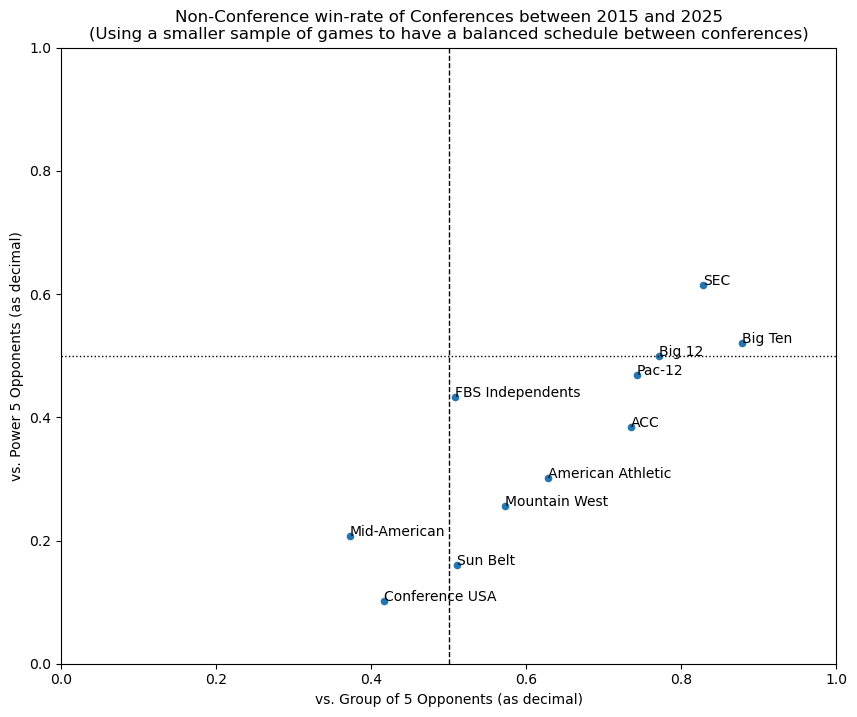

In [161]:
#find the average win percentage of each conference and plot the graphic
fbs_non_conference_record_last_20 = fbs_non_conference_by_school_for_overall.groupby(['conference_source', 'opponent_group'])['win-rate'].mean().reset_index()


to_plot = fbs_non_conference_record_last_20.pivot('conference_source', 'opponent_group', 'win-rate')[['Group of 5', 'Power 5']]

fig, ax = plt.subplots(figsize = (10,8))
to_plot.plot('Group of 5', 'Power 5', kind='scatter', ax=ax)
print(to_plot)
for k, v in to_plot.iterrows():
    ax.annotate(k, v)

# Labels and title
ax.set_title(f"Non-Conference win-rate of Conferences between {filter_season_year} and {year_end}" + 
             "\n(Using a smaller sample of games to have a balanced schedule between conferences)")
ax.set_xlabel("vs. Group of 5 Opponents (as decimal)")
ax.set_ylabel("vs. Power 5 Opponents (as decimal)")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# set a horizontal line at the 50% Power 5 win rate
ax.axhline(y=0.5, color='black', linestyle=':', linewidth=1, label='50% Power 5 win-rate')
    
# set a vertical line at the 50% Group of 5 win rate
ax.axvline(x=0.5, color='black', linestyle='--', linewidth=1, label='50% Group of 5 win-rate')
    

plt.show()

#### Key Takeaways
1. There appears to be a strong positive correlation between winning against Power 5 opponents and winning against Group of 5 opponents.
2. There may be 3 clusters of Conferences instead of just Power 5 and Group of 5.

## 3.3 - Plot Non-Conference Win Percent with a Trend Line
Create a plot for different conferences that has the scatter-plot of win percentages with some MSE and RMSE plots to help find a good balance of meaningfully fitting a curve to a line without over-fitting

Findings:
Power 5:
1. Power 5 Conferences tend to win more non-conference games than lose.
2. SEC has consistently been the best conference
3. ACC has been the worst conference
4. Power 5 Conferences have been trending stronger over time.
Group of 5:
1. The Group of 5 tends to lose more non-conference games than win.
2. Most conferences are relatively new
3. All but the Sun Belt have been generally declining in performance.

### 3.3.1 - Restructure the data

In [27]:
fbs_non_conference_0 = fbs_non_conference[['season', 'week', 'homeId', 'homeTeam', 'homeConference', 'homeOutcome']]
fbs_non_conference_1 = fbs_non_conference[['season', 'week', 'awayId', 'awayTeam', 'awayConference', 'awayOutcome']]

fbs_non_conference_0.rename({'homeID': 'schoolId',
                             'homeTeam': 'team',
                             'homeConference': 'conference',
                             'homeOutcome': 'outcome'}, inplace = True, axis = 'columns')

fbs_non_conference_1.rename({'awayID': 'schoolId',
                             'awayTeam': 'team',
                             'awayConference': 'conference',
                             'awayOutcome': 'outcome'}, inplace = True, axis = 'columns')

fbs_non_conference_by_school = pd.concat([fbs_non_conference_0, fbs_non_conference_1])


### 3.3.2 - Encode win/loss/tie as a number

In [28]:
fbs_non_conference_by_school = fbs_non_conference_by_school.replace({'outcome': {'Win': 1, 'Loss':0, 'Tie':0.5}})


#find the number of non-conference games played of each conference by season
fbs_non_conference_game_count = fbs_non_conference_by_school.groupby(['season', 'conference'])['outcome'].count().reset_index()
fbs_non_conference_game_count.rename({'outcome':'non_conference_games'}, inplace = True, axis = 'columns')

#find the average win percentage of each conference by season
fbs_non_conference_record = fbs_non_conference_by_school.groupby(['season', 'conference'])['outcome'].mean().reset_index()

fbs_non_conference_record = fbs_non_conference_record.merge(fbs_non_conference_game_count, how = 'left')

In [29]:
fbs_non_conference_record.describe()

,season,outcome,non_conference_games
count,1066.000000,1066.000000,1066.000000
mean,1976.759850,0.493077,37.765478
std,28.276942,0.163769,24.057899
min,1923.000000,0.000000,2.000000
25%,1954.000000,0.378611,26.000000
50%,1977.000000,0.500000,34.000000
75%,2001.000000,0.605110,43.000000
max,2024.000000,1.000000,185.000000


array([[<Axes: title={'center': 'non_conference_games'}>]], dtype=object)

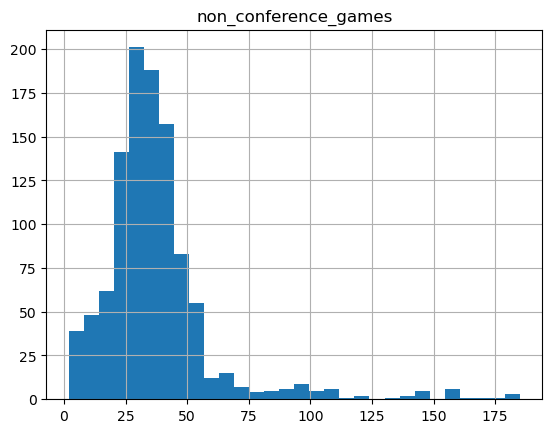

In [30]:
fbs_non_conference_record[['non_conference_games']].hist(bins=30)

#### Key Takeaway
1. For statistical significance, we should only use instances where a conference had 10 or more games. Only a minority of the data below that threshold

### 3.3.3 - Only keep non-conference records that were from 10 games or more

In [31]:
fbs_non_conference_record = fbs_non_conference_record[fbs_non_conference_record['non_conference_games']>=10]

In [32]:
# compute some quick stats
stats = pd.DataFrame({
"mean":fbs_non_conference_record.groupby('conference')['outcome'].mean(),
"median":fbs_non_conference_record.groupby('conference')['outcome'].median(),
"variance":fbs_non_conference_record.groupby('conference')['outcome'].var()})

stats.sort_values("mean", ascending=False)

,mean,median,variance
conference,,,
SEC,0.690930,0.694444,0.005950
Big Ten,0.594378,0.608696,0.014516
Pac-12,0.571945,0.575758,0.013186
Southwest,0.545874,0.556349,0.012012
American Athletic,0.531321,0.513900,0.015634
Big 12,0.512741,0.500000,0.019141
ACC,0.494926,0.509944,0.014740
FBS Independents,0.480447,0.488088,0.007759
Southland,0.470971,0.531250,0.013508


#### Key Takeaways
1. The SEC has tended to have the highest non-conference win rates and the lowest spread of non-conference win rates.
2. The ACC has had about as many non-conference wins as losses (worst of Power 5).
3. American Athletic Conference has tended to have more non-conference wins than losses (only one of current Group of 5)

### 3.3.4 - Prepare a helper function and print the conference win rates with a good-fit curve

In [33]:
smoothing_dict = {'Big Ten' : 0.9,
'Pac-12': 1.1,
'SEC' : 0.4,
'Big 12': 0.5,
'ACC': 0.5,
'American Athletic':0.3,
'Conference USA':0.07, 
'Mid-American':0.3, 
'Mountain West':0.2, 
'Sun Belt':0.2}

def print_one_conference(fbs_non_conference_record, conference, smoothing_factor):
    to_plot = fbs_non_conference_record[fbs_non_conference_record['conference']==conference]
    table = to_plot.pivot(index = 'season', columns='conference', values = 'outcome')
    #table.plot(ylim=[0,1])
    
    spline_df = pd.DataFrame()
    
    temp = table[[conference]].dropna()
    s = UnivariateSpline(temp.index.to_list(), temp[conference], s=smoothing_factor)
    xs = np.linspace(min(temp.index.to_list()), max(temp.index.to_list()), 1000)
    ys = s(xs)
    spline_df['Best-fit Line'] = ys
    
    spline_df.set_index(xs, inplace = True)
    all_spline_df = table.join(spline_df, how = 'outer')
    all_spline_df.plot(ylim = [0,1], xlim = [1918, year_end+2], style='o-', ms = 0.5)
    
    # plot horizontal line of the 50% win rate
    plt.hlines(0.5, 1918, year_end+2, colors='black', linestyles='dotted', label='50% Win-Rate')
    
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.title(f"Non-Conference Win Percentage of the {conference}\nSmoothing factor: {smoothing_factor}")
    plt.ylabel("Win Percent (as Decimal)")
    plt.xlabel("Season")
    #plt.savefig(f'{conference}.png', dpi=200, bbox_inches = 'tight')
    plt.show()
    
    df = pd.DataFrame(columns=['smooth', 'MSE'])
    for x in range(0,100):
        
        s = UnivariateSpline(temp.index.to_list(), temp[conference], s=x/100)
        
        df = pd.concat([df, pd.DataFrame(data={'smoothing factor' : x/100, 
                                               'MSE': mean_squared_error(s(temp.index.to_list()), temp[conference]), 
                                               'RMSE': mean_squared_error(s(temp.index.to_list()), temp[conference], squared = False)}, index = [0])])
    
    # If desired, the smoothing factors can be plotted to help optimize smoothing factor choices
    # df.plot("smoothing factor", 'MSE')
    # df.plot("smoothing factor", 'RMSE')

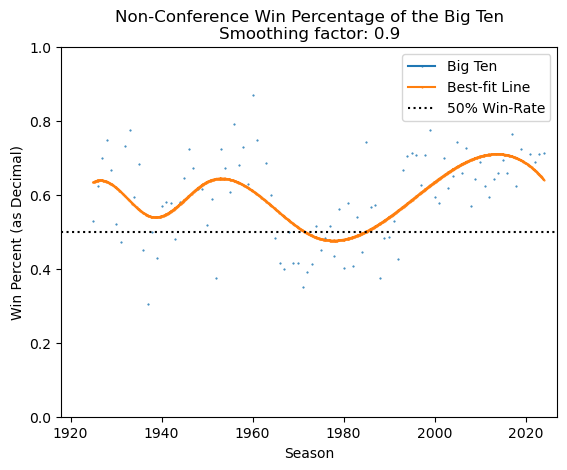

In [34]:
conference = 'Big Ten'
print_one_conference(fbs_non_conference_record, conference, smoothing_dict.get(conference))

#### Key Takeaways
1. Since 1980, the Big 10 has been increasing in strength, but has somewhat plateaued over the last 30 years.
2. Over the last 30 years, Big Ten has had a non-conference win percentage averaging around 70% despite the trend-line suggesting a dip in the last 10 years

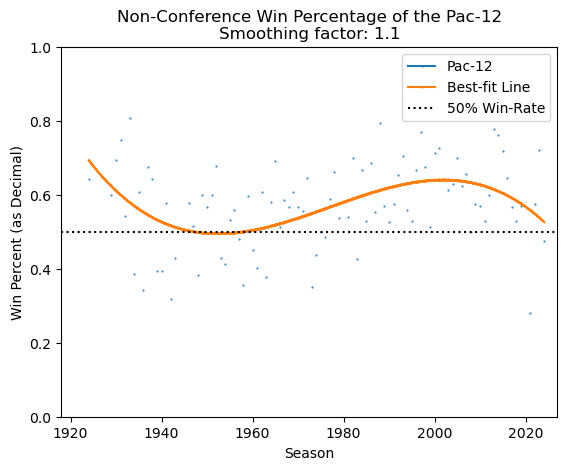

In [35]:
conference = 'Pac-12'
print_one_conference(fbs_non_conference_record, conference, smoothing_dict.get(conference))

#### Key Takeaway
1. Over the last 20 years, the Pac-12 has had a declining non-conference win percentage that is trending closer to 50%

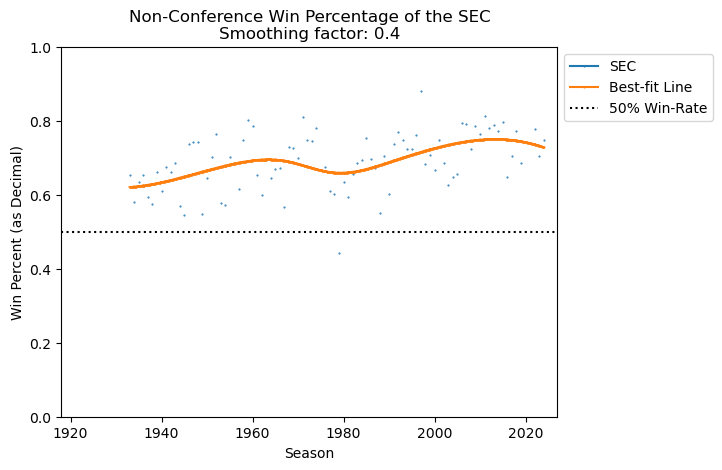

In [36]:
conference = 'SEC'
print_one_conference(fbs_non_conference_record, conference, smoothing_dict.get(conference))

#### Key Takeaway
1. The SEC has steadily grown in non-conference win percentage throughout it history to over 70% recently

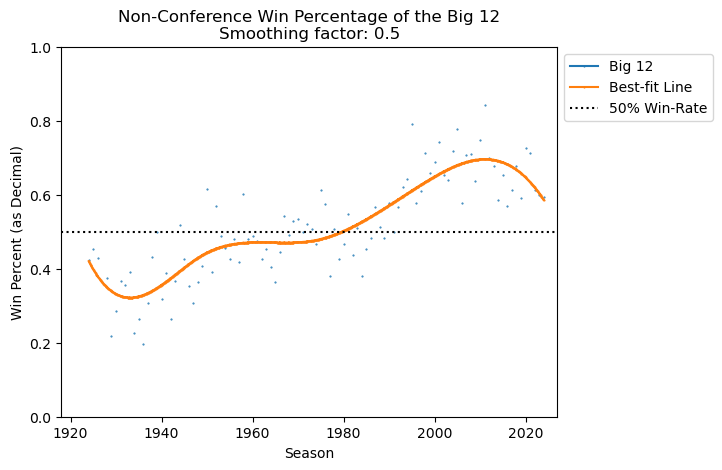

In [37]:
conference = 'Big 12'
print_one_conference(fbs_non_conference_record, conference, smoothing_dict.get(conference))

#### Key Takeaways
1. The Big 12 started weak and has grown in strength.
2. Over the last 10 years, there seems to have been a drop in their performance.

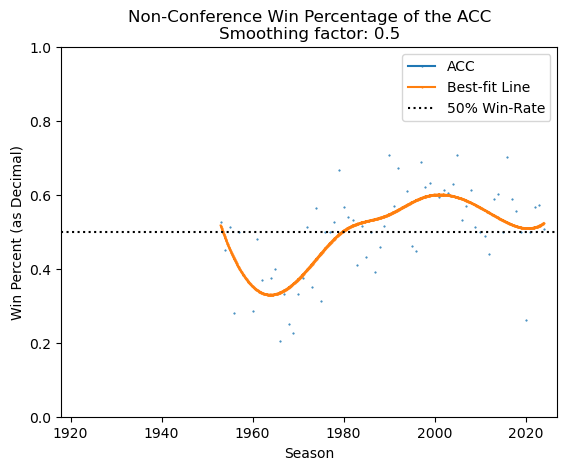

In [38]:
conference = 'ACC'
print_one_conference(fbs_non_conference_record, conference, smoothing_dict.get(conference))

#### Key Takeaway
1. The ACC has been improving its brand since the late 1960s, but has been declining slightly over the last 20 years.

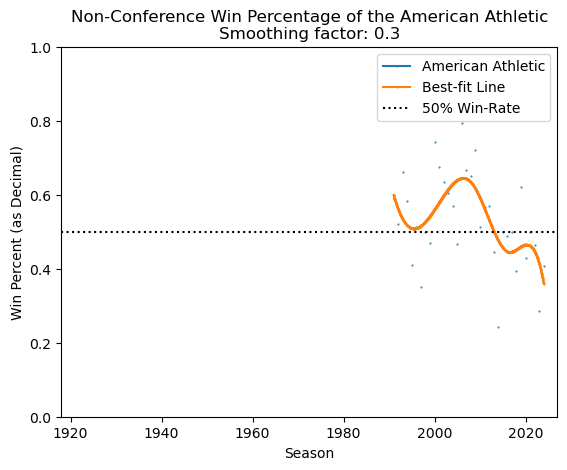

In [39]:
conference = 'American Athletic'
print_one_conference(fbs_non_conference_record, conference, smoothing_dict.get(conference))

#### Key Takeaways
1. The American Athletic Conference started generally winning more non-conference games than losing.
2. Over the last 20 years, it been declining sharply in performance.

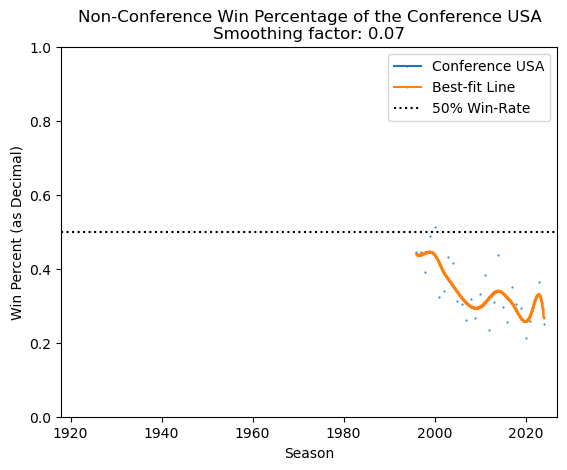

In [40]:
conference = 'Conference USA'
print_one_conference(fbs_non_conference_record, conference, smoothing_dict.get(conference))

#### Key Takeaways
1. Conference USA started generally loosing more non-conference games than winning
2. Since its inception, it has continued to decline in performance

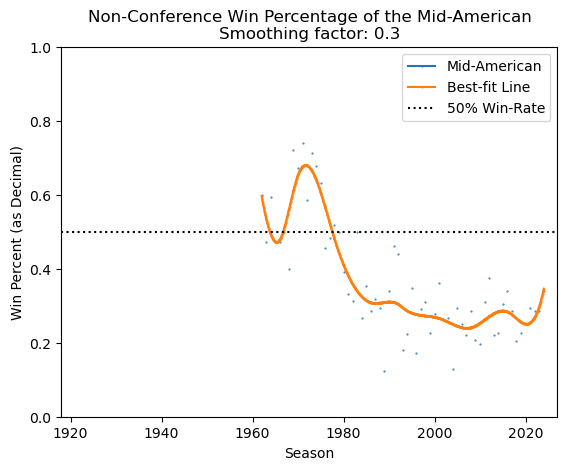

In [41]:
conference = 'Mid-American'
print_one_conference(fbs_non_conference_record, conference, smoothing_dict.get(conference))

#### Key Takeaways
1. The Mid-American Conference started generally winning more non-conference games than losing.
2. After its first 20 years, it began declining sharply in performance and has not recovered

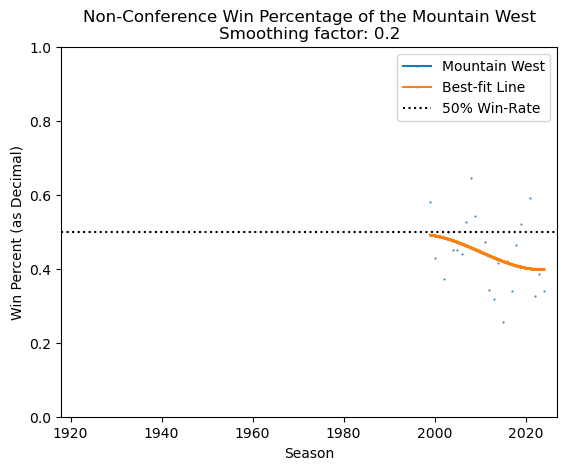

In [42]:
conference = 'Mountain West'
print_one_conference(fbs_non_conference_record, conference, smoothing_dict.get(conference))

#### Key Takeaways
1. The Mountain West Conference has started winning about as many non-conference games as it has loses.
2. Their performance has been declining since it began.

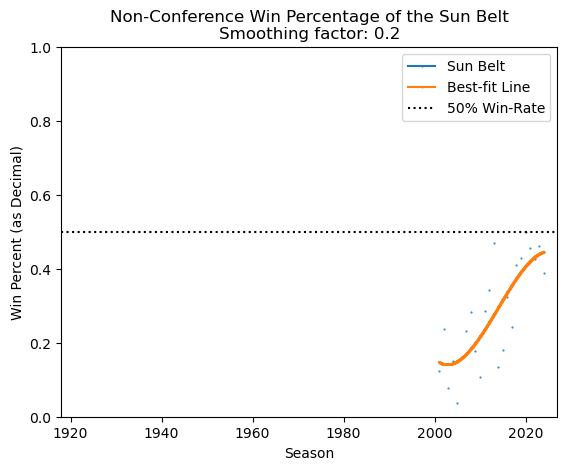

In [43]:
conference = 'Sun Belt'
print_one_conference(fbs_non_conference_record, conference, smoothing_dict.get(conference))

#### Key Takeaways
1. The Sun Belt Conference has started losing more non-conference games than it has won.
2. Since its inception, it has seen a sharp increase in performance.

### 3.3.5 - Prepare a helper function and print multiple conference good-fit curves of win rates together

In [44]:

#%% print conference charts

def print_chart(table, title, save_loc):
    all_spline_df = pd.DataFrame()
    
    counter = 0
    for conference in table.columns:
        counter += 1
    
        spline_df = pd.DataFrame()
    
        temp = table[[conference]].dropna()
        s = UnivariateSpline(temp.index.to_list(), temp[conference], s=smoothing_dict.get(conference,0.75))
        xs = np.linspace(min(temp.index.to_list()), max(temp.index.to_list()), 1000)
        ys = s(xs)
        spline_df[conference] = ys
    
        spline_df.set_index(xs, inplace = True)
        try:
            all_spline_df = all_spline_df.join(spline_df, how = 'outer')
        except:
            all_spline_df = spline_df
        
        if counter ==11:
            counter = 0
            all_spline_df.sort_index().plot(ylim = [0,1], xlim = [1918, year_end+2], marker='o', ms = 0.5)
            all_spline_df = pd.DataFrame()
            spline_df = pd.DataFrame()
            plt.legend(bbox_to_anchor=(1.0, 1.0))
            plt.title(title)
            plt.ylabel("Win Percent (as Decimal)")
            plt.xlabel("Season")
            plt.savefig(save_loc, dpi = 200, bbox_inches = 'tight')
            plt.show()
    
    all_spline_df.plot(ylim = [0,1], xlim = [1918, year_end+2], marker='o', ms = 0.5)
    plt.hlines(0.5, 1918, year_end+2, colors='black', linestyles='dotted', label='50% Win-Rate')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.title(title)
    plt.ylabel("Win Percent (as Decimal)")
    plt.xlabel("Season")
    #plt.savefig(save_loc, dpi=200, bbox_inches = 'tight')


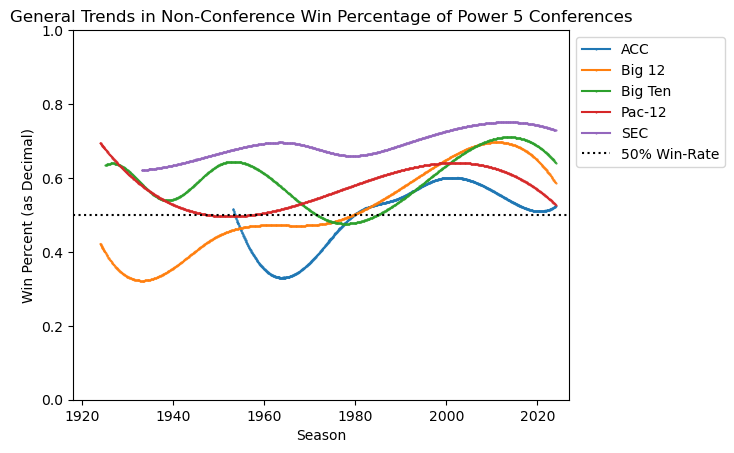

In [45]:
to_plot = fbs_non_conference_record[fbs_non_conference_record['conference'].isin(['ACC', 'Big Ten', 'Big 12', 'Pac-12', 'SEC'])]
table = to_plot.pivot(index = 'season', columns='conference', values = 'outcome')

print_chart(table, 'General Trends in Non-Conference Win Percentage of Power 5 Conferences', 'power-5.png')

#### Key Takeaways
1. Power 5 Conferences tend to win more non-conference games than lose.
2. SEC has consistently been the best conference
3. ACC has been the worst conference
4. Power 5 Conferences have been trending stronger over time.

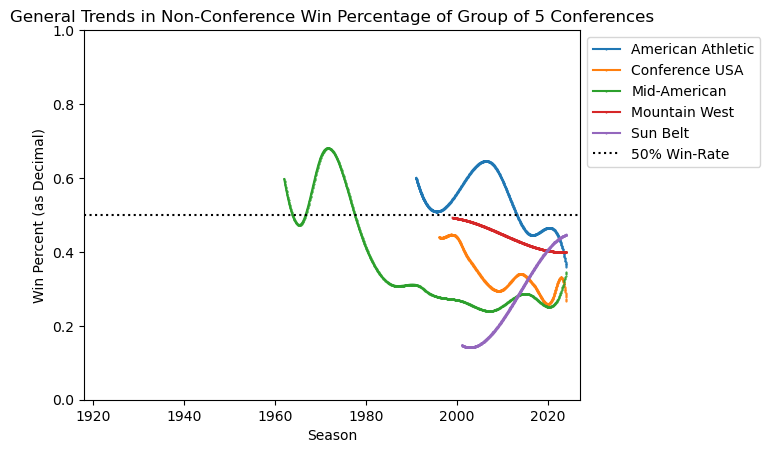

In [46]:
to_plot = fbs_non_conference_record[fbs_non_conference_record['conference'].isin(['American Athletic', 'Conference USA', 'Mid-American', 'Mountain West', 'Sun Belt'])]
table = to_plot.pivot(index = 'season', columns='conference', values = 'outcome')

print_chart(table, 'General Trends in Non-Conference Win Percentage of Group of 5 Conferences', 'group-of-5.png')

#### Key Takeaways
1. The Group of 5 tends to lose more non-conference games than win.
2. Most conferences are relatively new
3. All but the Sun Belt have been generally declining in performance.

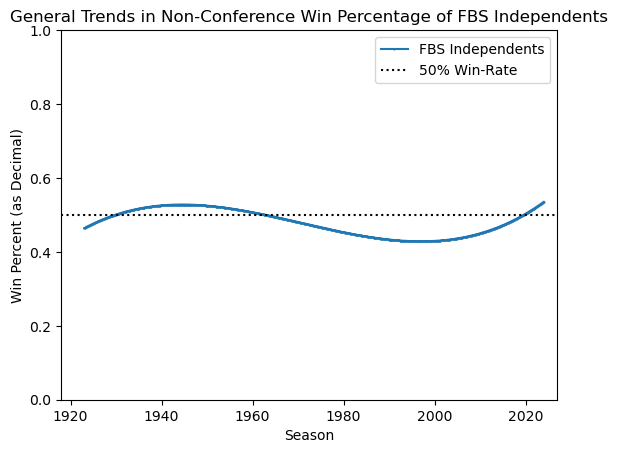

In [47]:
to_plot = fbs_non_conference_record[fbs_non_conference_record['conference'].isin(['FBS Independents'])]
table = to_plot.pivot(index = 'season', columns='conference', values = 'outcome')

print_chart(table, 'General Trends in Non-Conference Win Percentage of FBS Independents', 'independents.png')

#### Key Takeaway
1. Independents have generally won as many non-conference games they have lost over their whole history
2. Unlike other conference, they have not seen great changes in their non-conference win percentage.

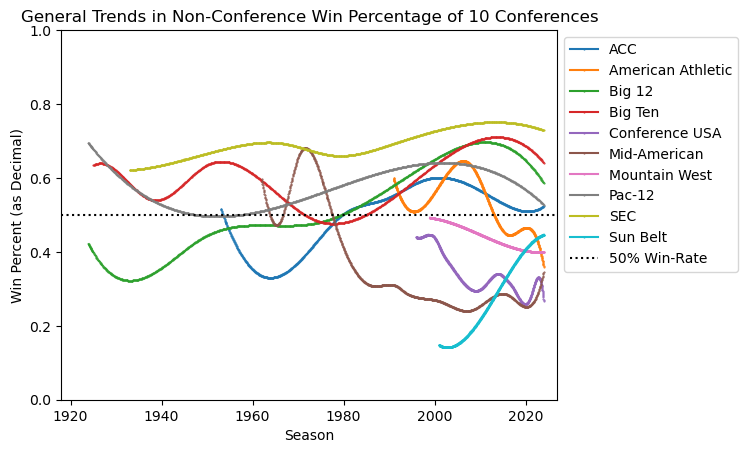

In [48]:
to_plot = fbs_non_conference_record[fbs_non_conference_record['conference'].isin(['ACC', 'Big Ten', 'Big 12', 'Pac-12', 'SEC','American Athletic', 'Conference USA', 'Mid-American', 'Mountain West', 'Sun Belt'])]
table = to_plot.pivot(index = 'season', columns='conference', values = 'outcome')

print_chart(table, 'General Trends in Non-Conference Win Percentage of 10 Conferences', 'active.png')

#### Key Takeaways
1. Power 5 tends to win more non-conference games than lose
2. Power 5 conferences have been around longer than Group of 5.

## 3.4 - What conferences tend to play each other?

Findings:
1. Power 5 teams have historically played others rather themselves
2. Power 5 teams are increasingly playing each other now.

### 3.4.1 Define what conferences are in the Power 5 and the Group of 5

In [49]:
current_conferences = ['ACC', 'Big Ten', 'Big 12', 'Pac-12', 'SEC','American Athletic', 'Conference USA', 'Mid-American', 'Mountain West', 'Sun Belt', 'FBS Independents']
current_groups = ['Power 5', 'Group of 5', 'FBS Independents', 'Defunct']
conference_group_dict = {'ACC' : 'Power 5', 
                         'Big Ten' : 'Power 5', 
                         'Big 12' : 'Power 5', 
                         'Pac-12' : 'Power 5', 
                         'SEC' : 'Power 5',
                         'American Athletic' : 'Group of 5', 
                         'Conference USA' : 'Group of 5', 
                         'Mid-American' : 'Group of 5', 
                         'Mountain West' : 'Group of 5', 
                         'Sun Belt' : 'Group of 5', 
                         'FBS Independents' : 'FBS Independents'
                        }

### 3.4.2 Find the Non-Conference schedule of the major conference groups
Re-organize and summarize the data

In [155]:
to_plot = fbs_non_conference.copy()
to_plot['homeGroup'] = to_plot['homeConference'].map(conference_group_dict).fillna('Defunct')
to_plot['awayGroup'] = to_plot['awayConference'].map(conference_group_dict).fillna('Defunct')

# identify what matchups as inside or outside the conference group 
# (When tallying a conference's the out of conference matchups, you have to look at both the home and away columns)
home_groups = to_plot[['season', 'homeGroup', 'awayGroup', 'id']]
away_groups = to_plot[['season', 'homeGroup', 'awayGroup', 'id']]

away_groups.rename({'homeGroup':'awayGroup', 'awayGroup':'homeGroup'})

conference_matchups = pd.concat([home_groups,away_groups])

# Because of the structure, there will be instances where a conf1 vs conf2 matchup will also show up as conf2 vs conf1.
# to mitigate this, new placeholder groupings columns will re-order matchups of conf2 vs conf 1 as conf 1 vs conf2
# this will make counting by distinct machup ('id' column) by conf matchup easier
conference_matchups['orderedGroupPairing'] = conference_matchups.apply(lambda x: sorted([str(x['homeGroup'][:]), str(x['awayGroup'][:])]), axis = 'columns')

conference_matchups['group1']= conference_matchups.apply(lambda x: x['orderedGroupPairing'][0], axis = 'columns')
conference_matchups['group2']= conference_matchups.apply(lambda x: x['orderedGroupPairing'][1], axis = 'columns')

groups_matchups = conference_matchups.groupby(['season', 'group1', 'group2'])['id'].nunique().reset_index()

#find the matchups by season (lower-triangular matrix)
conference_matchups_part_1 = groups_matchups[['season', 'group1', 'group2', 'id']].pivot_table(index = ['season', 'group2'], columns = 'group1', aggfunc = 'sum')

#do the same, but for group2 instead (upper-ish-triangular matrix). However, filter out inter-group meetings so they will not double-count when adding the two dataframes together
conference_matchups_part_2 = groups_matchups[groups_matchups['group1']!=groups_matchups['group2']][['season', 'group1', 'group2', 'id']].pivot_table(index = ['season', 'group1'], columns = 'group2', aggfunc = 'sum')
conference_matchups_part_2.index.names = ['season', 'group2']

## combine the upper and lower triangular matricies together into a full matrix
# --- Step 1: Get union of all columns and rows ---
all_columns = conference_matchups_part_1.columns.union(conference_matchups_part_2.columns)
all_rows = conference_matchups_part_1.index.union(conference_matchups_part_2.index)

# --- Step 2: Reindex both DataFrames to include all rows & columns ---
conference_matchups_part_1_aligned = conference_matchups_part_1.reindex(index=all_rows, columns=all_columns)
conference_matchups_part_2_aligned = conference_matchups_part_2.reindex(index=all_rows, columns=all_columns)

# --- Step 3 (Optional): Fill missing values ---
conference_matchups_part_1_filled = conference_matchups_part_1_aligned.fillna(0)
conference_matchups_part_2_filled = conference_matchups_part_2_aligned.fillna(0)

conference_matchups_overall = conference_matchups_part_1_filled.add(conference_matchups_part_2_filled, fill_value = 0)

# restructure the data so it is back into a conf1 vs conf2 and conf2 vs conf1 format
# but now the matchup counts will be equal between conf1 vs conf2 and conf2 vs conf1 
counts = conference_matchups_overall.droplevel(level = 0, axis = 1).reset_index().melt(id_vars = ['season','group2'], value_vars = current_groups, var_name= "group1", value_name = 'count')

counts['count'].fillna(0, inplace = True)
non_conference_counts = counts.copy() #[counts['homeGroup'] != counts['awayGroup']]

# for one column find the total non-conference matchups that season
group_count = non_conference_counts.groupby(['season','group1'])[['count']].sum().reset_index()

merged_data = non_conference_counts.merge(group_count, how = 'outer', on = ['season','group1'])
merged_data.rename({'count_x': 'away_conference_games', 'count_y': 'total_away_conference_games'}, axis = 'columns', inplace = True)

# divide the number of matchups against one group by the total non-conference matchups to get non-conference schedule percent for that confernce group
merged_data['non_conference_percent'] = merged_data['away_conference_games'].div(merged_data['total_away_conference_games'])


Define a helper function to print 

In [156]:
def print_group_schedule_plots(group, merged_data):
    data_to_plot = merged_data[merged_data['group1']==group]
    counts = pd.pivot_table(data_to_plot, values='non_conference_percent', index='season', columns='group2',
               aggfunc='sum')
    
    # Define custom colors for each column
    custom_colors_source = {
       'Power 5': '#FF9999',    # light red
        'Group of 5': '#FFD700',   # gold
        'FBS Independents': '#add8e6',   # light blue
        'Defunct': '#63666A' # light grey
    }

    custom_colors = {group: custom_colors_source.get(group)}

    for k,v in custom_colors_source.items():
        if k != group:
            custom_colors[k] = v

    
    # Define custom legend order
    legend_order = list(custom_colors.keys())
    
    
    counts = counts[legend_order]

    # Plot the area chart with custom colors
    ax = counts.plot(
        color=[custom_colors[col] for col in counts.columns]  # match DataFrame column order
    )
    # set a horizontal line at the 50% schedule / win rate
    ax.axhline(y=0.5, color='black', linestyle=':', linewidth=1, label='50% Schedule-Rate')
        

    # Reorder legend manually
    handles, labels = ax.get_legend_handles_labels()
    label_to_handle = dict(zip(labels, handles))
    ax.legend(
        [label_to_handle[label] for label in legend_order],
        legend_order,
        title="Groups",
        loc='upper left'
    )

    # Labels and title
    ax.set_title(f"Non-Conference Schedule Percentage of the {group}")
    ax.set_xlabel("Season")
    ax.set_ylabel("Percent of non-conference schedule (as decimal)")
    ax.set_xlim([1918, year_end+2])
    ax.set_ylim([0, 1])

    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()
    plt.show()


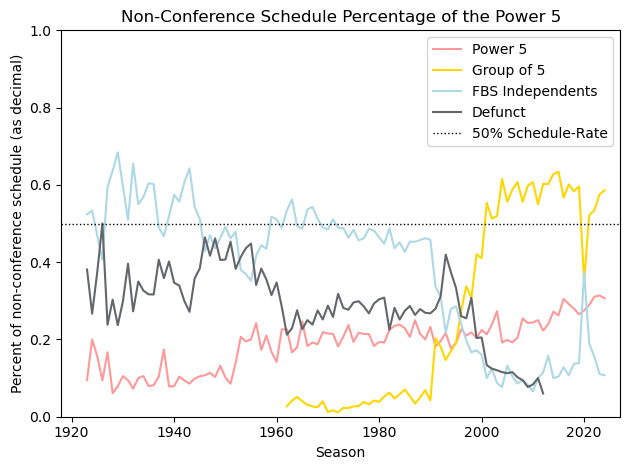

In [157]:
group = 'Power 5'
print_group_schedule_plots(group, merged_data)

#### Key Takeaways
1. Power 5 teams have historically played others rather themselves
2. Power 5 teams are increasingly playing each other now.

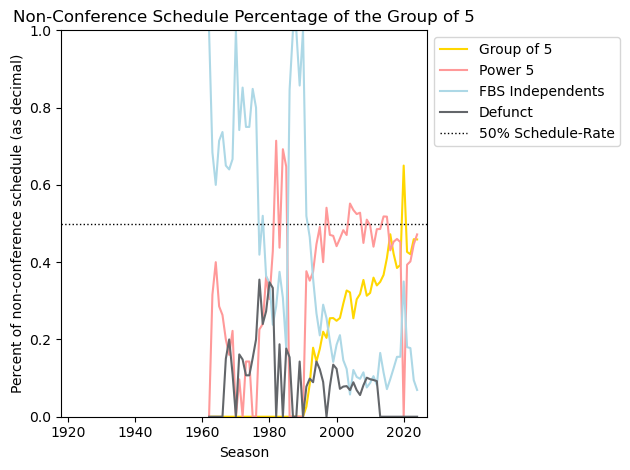

In [53]:
group = 'Group of 5'
print_group_schedule_plots(group, merged_data)

#### Key Takeaways
1. Group of 5 have been predominately scheduled against the Power 5
2. Group of 5 is increasingly playing among each other.

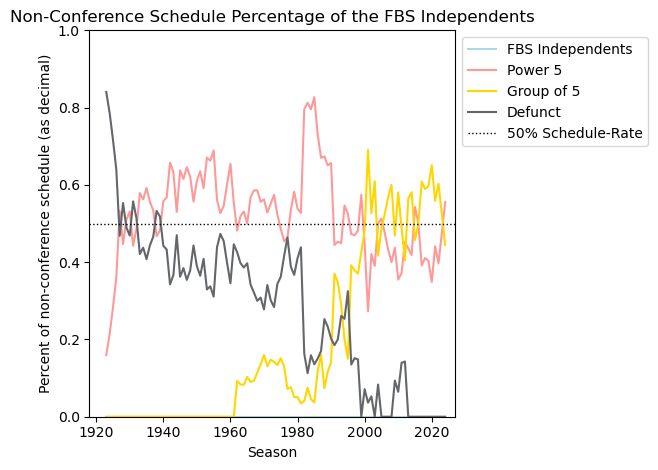

In [54]:
group = 'FBS Independents'
print_group_schedule_plots(group, merged_data)

#### Key Takeaways
1. Independents used to play with Power 5 more. Now they are playing them less.

## 3.5 - Where are the wins/loses coming from?

Findings:

Power 5 conferences tend to beat Group of 5 Conferences
Within the Power 5, there seems to be 2 strong scheduling relationships:
1. SEC/ACC (~50% of their Power 5 schedule)
   - SEC tends to beat ACC (~65%) more than they beat others Power 5 conferences, but only by a few percentage points. Thus, the scheduling imbalance does not inflate their non-conference win percentage too much.
2. Pac-12/Big-Ten/Big-12 (~50% of their Power 5 schedule)
   - Big Ten seems to be the best by tending to beat Big 12 (~56%) while remaining about even with the Pac 12

There is no discernible scheduling relationship at the Group of 5 level

American Athletic has performed more like a Power 5 conference than a Group of 5 conference.

American Athletic Conference has been at the top of the Group of 5 while Mid American has been at the bottom.

However, American Athletic has seen a drop in Group of 5 wins while the Sun Belt has seen an increase within the Group of 5. 

### 3.5.0 - Define some terms

In [55]:
current_conferences = ['ACC', 'Big Ten', 'Big 12', 'Pac-12', 'SEC','American Athletic', 'Conference USA', 'Mid-American', 'Mountain West', 'Sun Belt', 'FBS Independents']
current_groups = ['Power 5', 'Group of 5', 'FBS Independents', 'Defunct']
conference_group_dict = {'ACC' : 'Power 5', 
                         'Big Ten' : 'Power 5', 
                         'Big 12' : 'Power 5', 
                         'Pac-12' : 'Power 5', 
                         'SEC' : 'Power 5',
                         'American Athletic' : 'Group of 5', 
                         'Conference USA' : 'Group of 5', 
                         'Mid-American' : 'Group of 5', 
                         'Mountain West' : 'Group of 5', 
                         'Sun Belt' : 'Group of 5', 
                         'FBS Independents' : 'FBS Independents'
                        }

### 3.5.1 - How often do conferences play each other by conference groups and what are the outcomes?

Findings:

Power 5
Big Ten
1. Historically, the Big Ten has played an estimated 30-60% of their non-conference games with Power 5 opponents.
2. Recently, the Big Ten has scheduled more games with the Power 5 and improved their record against them slightly.
3. Big Ten has consistently beaten Group of 5 teams.
4. Big Ten is playing more Group of 5 now instead of Independents. (Perhaps Independents have moved to the Group of 5)

Pac 12
1. The PAC-12 has scheduled an estimate 30-50% of non-conference games with the Power 5.
2. The PAC-12 typically wins as many games as they lose.
3. PAC-12 has regularly beaten Group of 5 teams, albeit at not a high rate.
4. Since the late 1960s, PAC-12 has played fewer Independents and more non-Power 5 conferences. (Perhaps Independents have moved to the Group of 5)

SEC
1. Historically, the SEC has scheduled an estimated 25-40% of its non-conference games with Power 5 opponents.
2. SEC typically wins an estimated 65% of its Power 5 non-conference games.
3. SEC has consistently beaten Group of 5 and Defunct conference opponents.
4. Since the late 1990s, SEC has started to play Power 5 increasingly more frequently.

Big 12
1. Historically, the Big 12 has scheduled an estimated 10-30% of its non-conference games with Power 5 opponents.
2. When the Big 12 has played Power 5, they tend to win as many games as the lose.
3. Big 12 has consistently beaten Group of 5 conference opponents.
4. Since the late 1990s (and maybe the 1960's), Big 12 has started to play Power 5 increasingly more frequently.

ACC
1. Historically, the ACC has scheduled 25-40% of its non-conference games with Power 5 opponents. Although that is rising
2. ACC has typically lost against most of its Power 5 opponents.
3. ACC has consistently beaten Group of 5 opponents. Albeit at not a high percentage.
4. Since the late 1970s, ACC has started to play Power 5 increasingly more frequently.


Group of 5
American Athletic
1. American Athletic has had an estimated 30-60% win-rate against Power 5, but that has been decreasing over the last 10 years.
2. American Athletic has historically won most of its games against Group of 5, but not as much recently
3. American Athletic has played about the same amount of Power 5 opponents as non-Power 5. Although, they may be declining over that last 10 years.

Conference USA
1. Conference USA has not done well against Power 5.
2. As Conference USA is scheduling more Group of 5 games, it win-rate against them has not increased.
3. Conference USA has played about the same amount of Power 5 opponents as non-Power 5. Although, they may be declining over that last 10 years.

Mid American
1. Mid-American has not done well against Power 5 and has lost more games than won against the Group of 5.
2. As Mid-American is scheduling more Group of 5 games, it win-rate against them seems to be increasing slightly.
3. Mid-American has played about the same amount of Power 5 opponents as non-Power 5.

Mountain West
1. Mountain West has not done well against Power 5. They are playing them less and losing more.
2. Mountain West has won an estimated 40-60 percent of its games against the Group of 5.
3. As Mountain West is scheduling more Group of 5 games, it win-rate against them has remained about the same (40-60%).
4. Mountain West has played about the same amount of Power 5 opponents as non-Power 5.

Sun Belt
1. Sun Belt has not done well against Power 5. They are playing them less but seem to be winning more.
2. Sun Belt is a rising star within the Group of 5 by playing them more and winning more.

#### 3.5.1.1 - Get the percent of non-conference games' schedule by Group of conferences

In [56]:
to_plot = fbs_non_conference.copy()
conference_matchups_part_1 = to_plot[['season', 'homeConference', 'awayConference', 'id']].pivot_table(index = ['season', 'homeConference'], columns = 'awayConference', aggfunc = 'count').fillna(0)
conference_matchups_part_2 = to_plot[['season', 'homeConference', 'awayConference', 'id']].pivot_table(index = ['season', 'awayConference'], columns = 'homeConference', aggfunc = 'count').fillna(0)

conference_matchups_part_2.index.names = ['season', 'homeConference']
conference_matchups_overall = conference_matchups_part_1+conference_matchups_part_2

all_conferences = conference_matchups_overall.droplevel(level = 0, axis = 0).index.drop_duplicates()

counts = conference_matchups_overall.droplevel(level = 0, axis = 1).reset_index().melt(id_vars = ['season','homeConference'], value_vars = all_conferences, var_name= "awayConference", value_name = 'count')

counts['count'].fillna(0, inplace = True)
non_conference_counts = counts[counts['homeConference'] != counts['awayConference']]

group_count = non_conference_counts.groupby(['season','homeConference'])[['count']].sum().reset_index()

merged_data = non_conference_counts.merge(group_count, how = 'outer', on = ['season','homeConference'])
merged_data.rename({'count_x': 'away_conference_games', 'count_y': 'total_away_conference_games'}, axis = 'columns', inplace = True)

merged_data['non_conference_percent'] = merged_data['away_conference_games'].div(merged_data['total_away_conference_games'])


#### 3.5.1.2 - Combine Data

In [57]:
fbs_non_conference_0 = fbs_non_conference[['season', 'week', 'homeId', 'homeTeam', 'homeConference', 'homeOutcome', 'awayConference']]
fbs_non_conference_1 = fbs_non_conference[['season', 'week', 'awayId', 'awayTeam', 'awayConference', 'awayOutcome', 'homeConference']]

fbs_non_conference_0.rename({'homeID': 'schoolId',
                             'homeTeam': 'team',
                             'homeConference': 'conference',
                             'homeOutcome': 'outcome',
                             'awayConference': 'opposingConference'}, inplace = True, axis = 'columns')

fbs_non_conference_1.rename({'awayID': 'schoolId',
                             'awayTeam': 'team',
                             'awayConference': 'conference',
                             'awayOutcome': 'outcome',
                             'homeConference': 'opposingConference'}, inplace = True, axis = 'columns')

fbs_non_conference_by_school = pd.concat([fbs_non_conference_0, fbs_non_conference_1])

fbs_non_conference_by_school = fbs_non_conference_by_school.replace({'outcome': {'Win': 1, 'Loss':0, 'Tie':0.5}})
fbs_non_conference_by_school['opposingConferenceGroup'] = fbs_non_conference_by_school['opposingConference'].map(conference_group_dict).fillna('Defunct')

#find the number of non-conference games played of each conference by season
fbs_non_conference_game_count = fbs_non_conference_by_school.groupby(['season', 'conference', 'opposingConferenceGroup'])['outcome'].count().reset_index()
fbs_non_conference_game_count.rename({'outcome':'non_conference_games'}, inplace = True, axis = 'columns')

#find the average win percentage of each conference by season
fbs_non_conference_record = fbs_non_conference_by_school.groupby(['season', 'conference', 'opposingConferenceGroup'])['outcome'].mean().reset_index()


#### 3.5.1.3 Merge Conference Schedule and Win Rates

In [58]:

#bring in the conference schedule percents
schedule_data = merged_data.copy()

schedule_data.rename({'homeConference': 'conference',
                      'awayConference': 'opposingConference'}, inplace = True, axis = 'columns')

schedule_data['opposingConferenceGroup'] = schedule_data['opposingConference'].map(conference_group_dict).fillna('Defunct')

schedule_data_count_of_conf_groups = schedule_data.groupby(['season','conference', 'opposingConferenceGroup'])[['away_conference_games']].sum().reset_index()
schedule_data_count_of_non_conf = schedule_data.groupby(['season','conference', 'opposingConferenceGroup'])[['total_away_conference_games']].mean().reset_index()

schedule_data_full = schedule_data_count_of_conf_groups.merge(schedule_data_count_of_non_conf, how = 'left')

schedule_data_full['non_conference_percent'] = schedule_data_full['away_conference_games'].div(schedule_data_full['total_away_conference_games'])

fbs_non_conference_record = fbs_non_conference_record.merge(fbs_non_conference_game_count, how = 'left')

fbs_non_conference_record_with_schedule = fbs_non_conference_record.merge(schedule_data_full, how = 'left')

#### 3.5.1.4 Make a helper function to print schedule and win rate together

In [59]:
def print_conference_schedule_performance(group, fbs_non_conference_record_with_schedule):
    if group == 'FBS Independents':
        return None
    data_to_plot = fbs_non_conference_record_with_schedule[fbs_non_conference_record_with_schedule['conference']==group]
    #data_to_plot['opposingConferenceGroup'] = data_to_plot['awayConference'].map(conference_group_dict).fillna('Defunct')

    
    counts = pd.pivot_table(data_to_plot, values='non_conference_percent', index='season', columns='opposingConferenceGroup',
               aggfunc='sum')    
    
    win_rate = pd.pivot_table(data_to_plot, values='outcome', index='season', columns='opposingConferenceGroup',
                 aggfunc='sum')    
    
    # Define custom colors for each column
    custom_colors_source = {
        'Power 5': '#FF9999',    # light red
        'Group of 5': '#FFD700',   # gold
        'FBS Independents': '#add8e6',   # light blue
        'Defunct': '#63666A' # light grey
    }

    custom_colors = {conference_group_dict.get(group): custom_colors_source.get(conference_group_dict.get(group))}
    
    for k,v in custom_colors_source.items():
        if k != conference_group_dict[group]:
            custom_colors[k] = v
    
    # Create subplots
    fig, axes = plt.subplots(4, 1, figsize=(6, 6), sharex=True)

    # Plot data on each subplot
    for i in range(0,4):
        # set a horizontal line at the 50% schedule / win rate
        axes[i].axhline(y=0.5, color='black', linestyle=':', linewidth=1, label='50% Schedule/Win-Rate')
        
        # plot schedule rate and win rate
        conference = list(custom_colors_source.keys())[i]
        axes[i].plot(counts.index, counts[conference], label=f"Schedule % with {conference}", color=custom_colors_source[conference])
        axes[i].plot(win_rate.index, win_rate[conference], label=f"Win Rate over {conference}", color=custom_colors_source[conference], linestyle = '--')
        
        
        axes[i].set_title(conference)
        
        axes[i].set_ylim([0, 1])
        axes[i].set_xlim([1918, year_end+2])

    # Adjust layout
    fig.tight_layout()

    # Add a shared legend outside the plot
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)
    
    fig.suptitle(f"Non-Conference Schedule Percentage and Win Rate of the {group}")
    
    fig.subplots_adjust(top=0.9)
    # Define custom legend order
    # legend_order = list(custom_colors.keys())
    
    
    # counts = counts[legend_order]

    # Plot the area chart with custom colors
    # ax = counts.plot(
    #     color=[custom_colors[col] for col in counts.columns]  # match DataFrame column order
    # )
    
    plt.show()
    
    # Reorder legend manually
    # handles, labels = ax.get_legend_handles_labels()
    # label_to_handle = dict(zip(labels, handles))
    # ax.legend(
    #     [label_to_handle[label] for label in legend_order],
    #     legend_order,
    #     title="Groups",
    #     loc='upper left'
    # )

    # Labels and title
    # ax.set_title(f"Non-Conference Schedule Percentage of the {group}")
    # ax.set_xlabel("Schedule Percent (as Decimal)")
    # ax.set_ylabel("Percent of non-conference schedule")
    # ax.set_xlim([1918, year_end+2])
    # ax.set_ylim([0, 1])

    # plt.legend(bbox_to_anchor=(1.0, 1.0))
    # plt.tight_layout()
    # plt.show()


#### 3.5.1.5 - Get the non-conference win percentage against a particular conference group

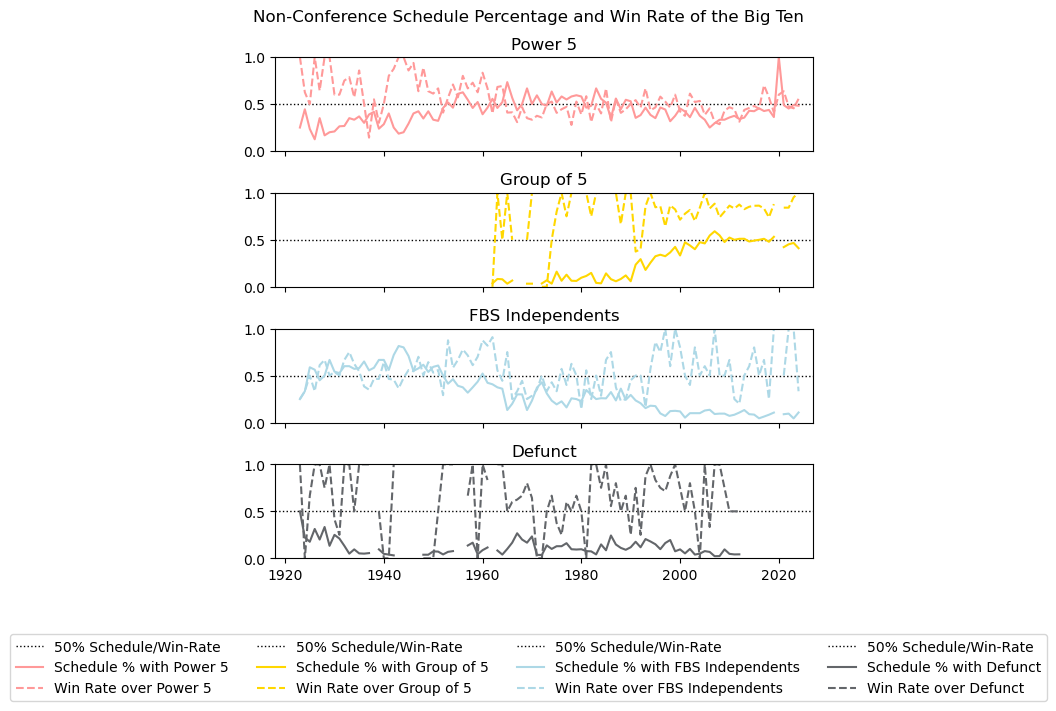

In [60]:
conference = 'Big Ten'
print_conference_schedule_performance(conference, fbs_non_conference_record_with_schedule)

#### Key Takeaways:
1. Historically, the Big Ten has played an estimated 30-60% of their non-conference games with Power 5 opponents.
2. Recently, the Big Ten has scheduled more games with the Power 5 and improved their record against them slightly.
3. Big Ten has consistently beaten Group of 5 teams.
4. Big Ten is playing more Group of 5 now instead of Independents. (Perhaps Independents have moved to the Group of 5)

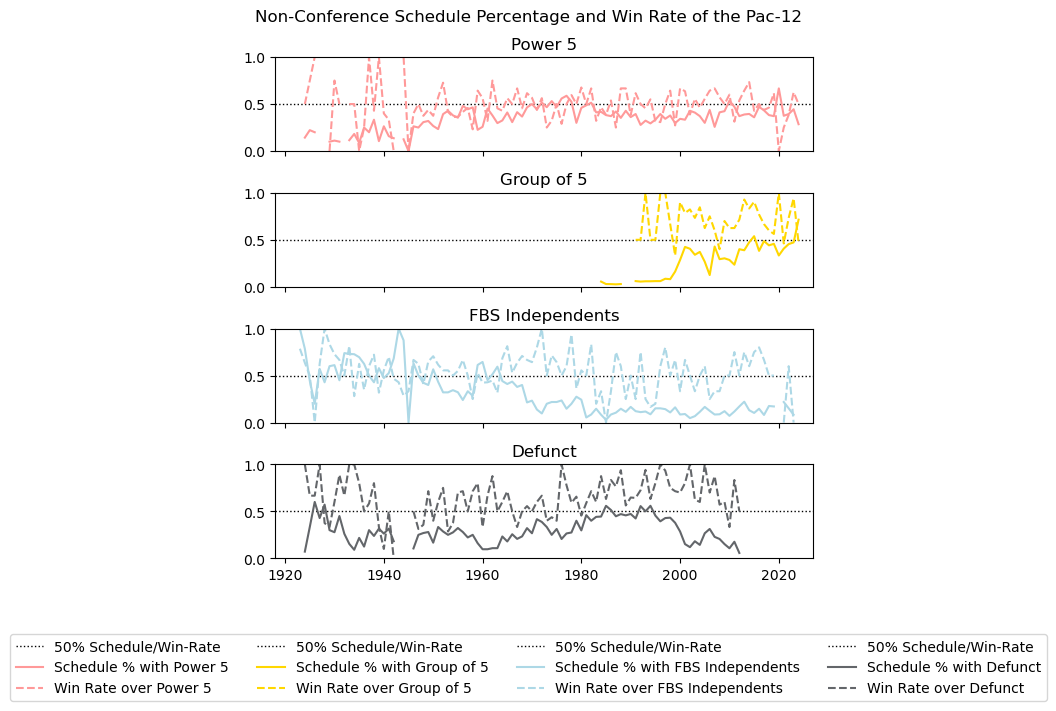

In [61]:
conference = 'Pac-12'
print_conference_schedule_performance(conference, fbs_non_conference_record_with_schedule)

#### Key Takeaways:
1. The PAC-12 has scheduled an estimeate 30-50% of non-conference games with the Power 5.
2. Teh PAC-12 typically wins as many games as they lose.
3. PAC-12 has regularly beaten Group of 5 teams, albeit at not a high rate.
4. Since the late 1960s, PAC-12 has played fewer Independents and more non-Power 5 conferences. (Perhaps Independents have moved to the Group of 5)

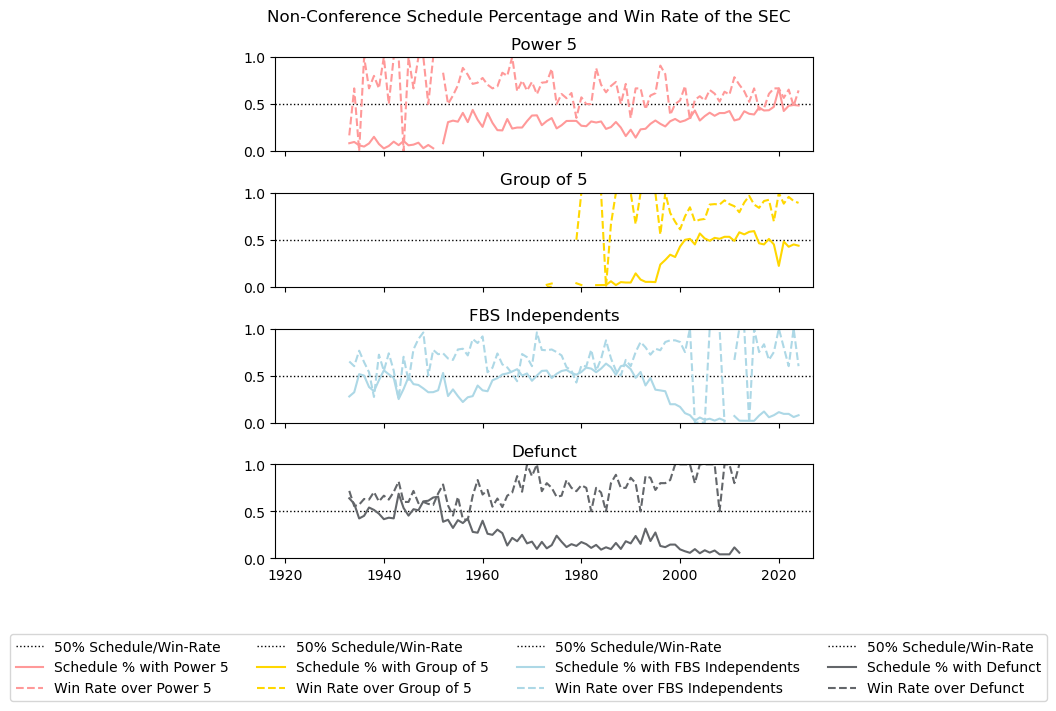

In [62]:
conference = 'SEC'
print_conference_schedule_performance(conference, fbs_non_conference_record_with_schedule)

#### Key Takeaways:
1. Historically, the SEC has scheduled and estimated 25-40% of its non-conference games with Power 5 opponents.
2. SEC typically wins an estimated 65% if its Power 5 non-conference games.
3. SEC has consistently beaten Group of 5 and Defunct conference opponents.
4. Since the late 1990s, SEC has started to play Power 5 increasingly more frequently.

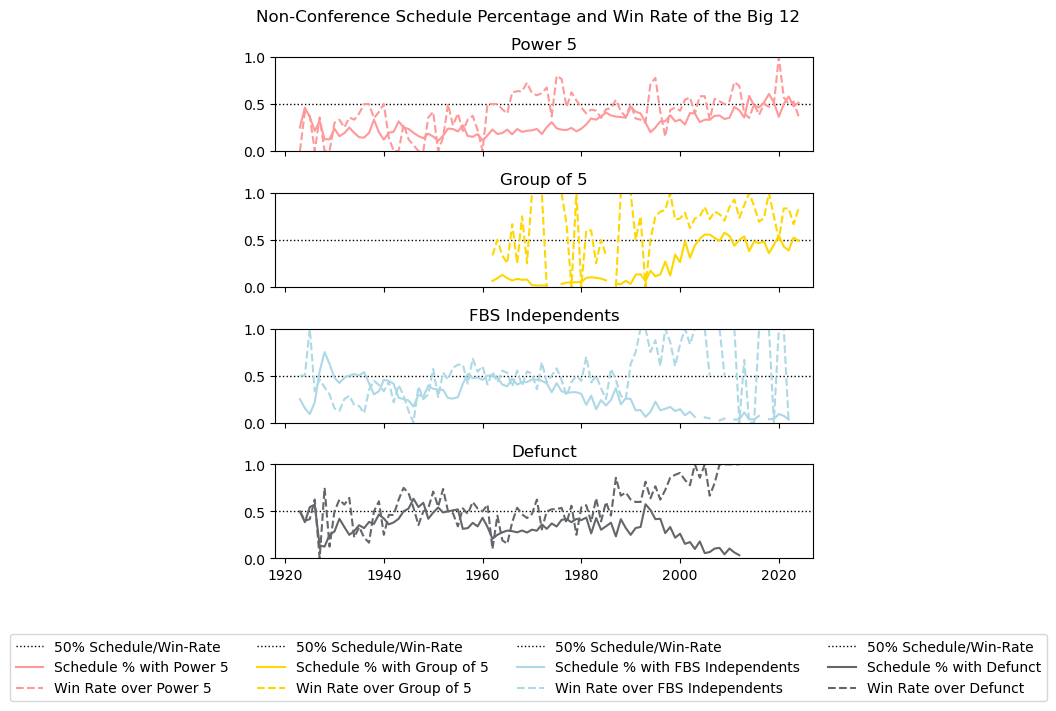

In [63]:
conference = 'Big 12'
print_conference_schedule_performance(conference, fbs_non_conference_record_with_schedule)

#### Key Takeaways:
1. Historically, the Big 12 has scheduled an estimated 10-30% of its non-conference games with Power 5 opponents.
2. When the Big 12 has played Power 5, they tend to win as many games as the lose.
3. Big 12 has consistently beaten Group of 5 conference opponents.
4. Since the late 1990s (and maybe the 1960's), Big 12 has started to play Power 5 increasingly more frequently.

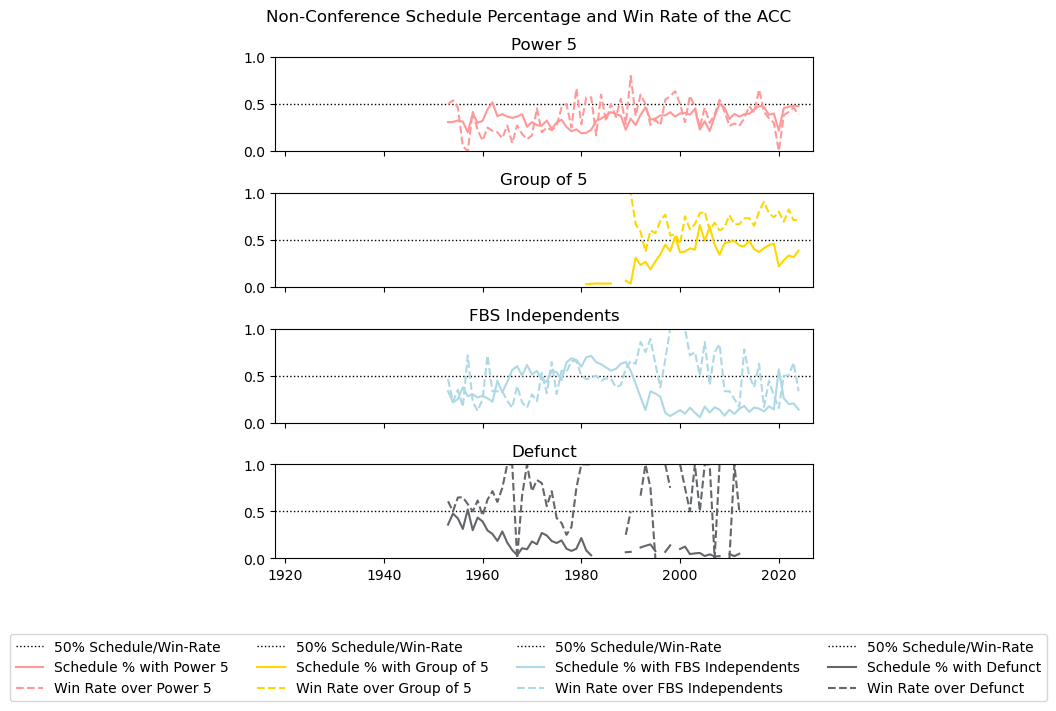

In [64]:
conference = 'ACC'
print_conference_schedule_performance(conference, fbs_non_conference_record_with_schedule)

#### Key Takeaways:
1. Historically, the ACC has scheduled 25-40% of its non-conference games with Power 5 opponents. Although that is rising
2. ACC has typically lost against most of its Power 5 opponents.
3. ACC has consistently beaten Group of 5 opponents. Albeit at not a high percentage.
4. Since the late 1970s, ACC has started to play Power 5 increasingly more frequently.

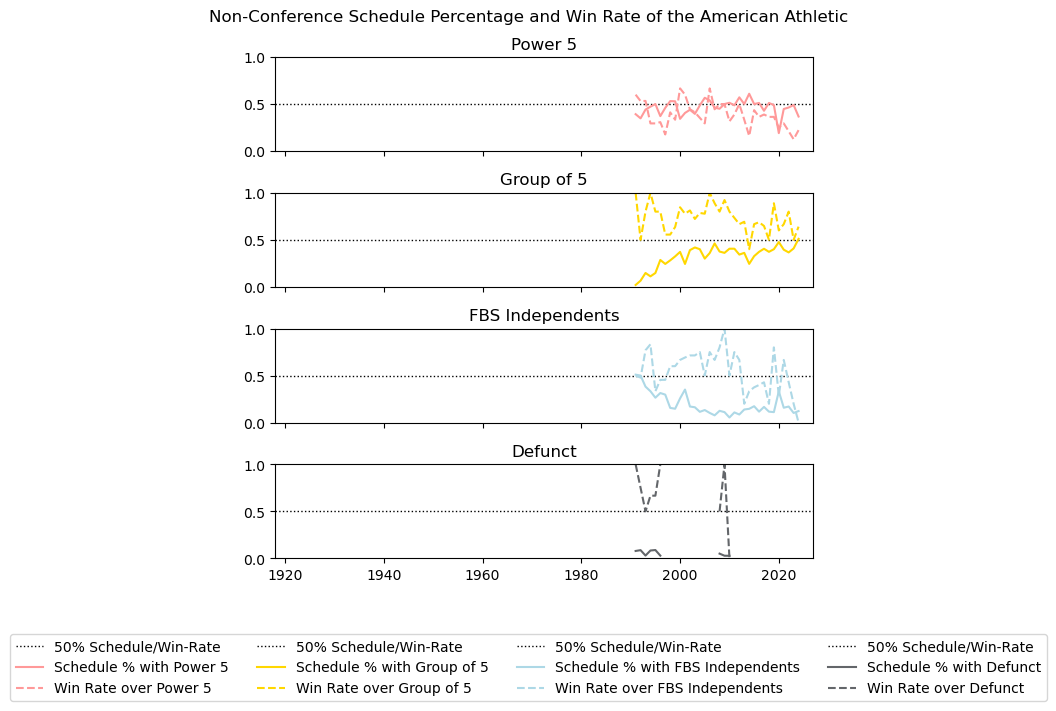

In [65]:
conference = 'American Athletic'
print_conference_schedule_performance(conference, fbs_non_conference_record_with_schedule)

#### Key Takeaways:
1. American Athletic has had an estimated 30-60% win-rate against Power 5, but that has been decreasing over the last 10 years.
2. American Athletic has historically won most of its games against Group of 5, but not as much recently
3. American Athletic has played about the same amount of Power 5 opponents as non-Power 5. Although, they may be declining over that last 10 years.

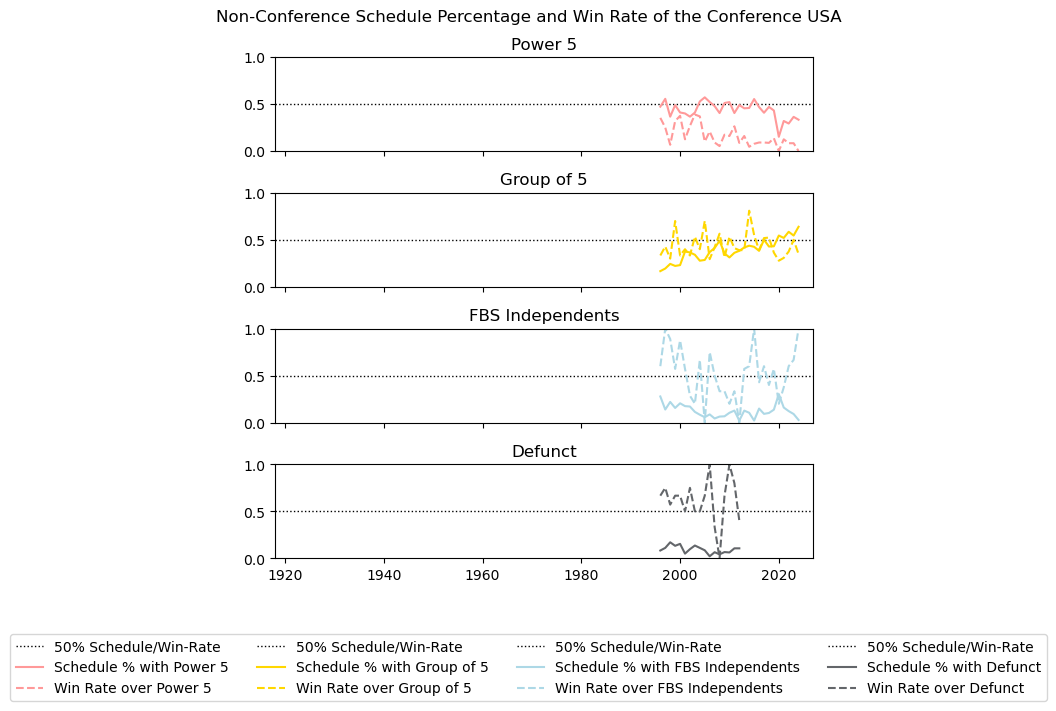

In [66]:
conference = 'Conference USA'
print_conference_schedule_performance(conference, fbs_non_conference_record_with_schedule)

#### Key Takeaways:
1. Conference USA has not done well against Power 5.
2. As Conference USA is scheduling more Group of 5 games, it win-rate against them has not increased.
3. Conference USA has played about the same amount of Power 5 opponents as non-Power 5. Although, they may be declining over that last 10 years.

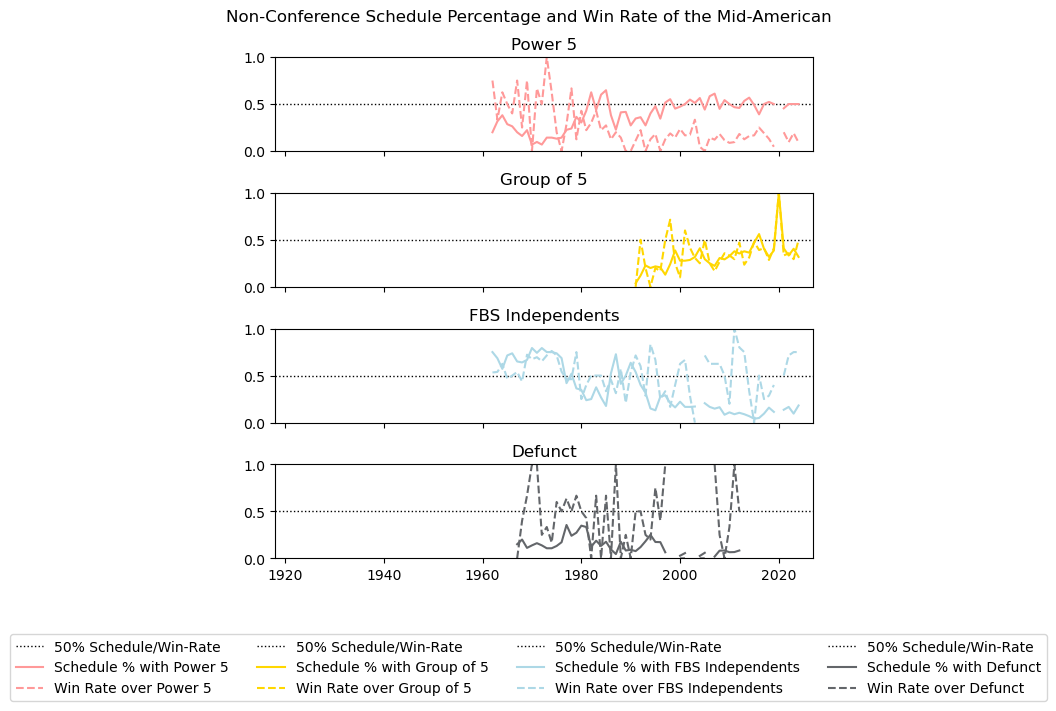

In [67]:
conference = 'Mid-American'
print_conference_schedule_performance(conference, fbs_non_conference_record_with_schedule)

#### Key Takeaways:
1. Mid-American has not done well against Power 5 and has lost more games than won against the Group of 5.
2. As Mid-American is scheduling more Group of 5 games, it win-rate against them seems to be increasing slightly.
3. Mid-American has played about the same amount of Power 5 opponents as non-Power 5.

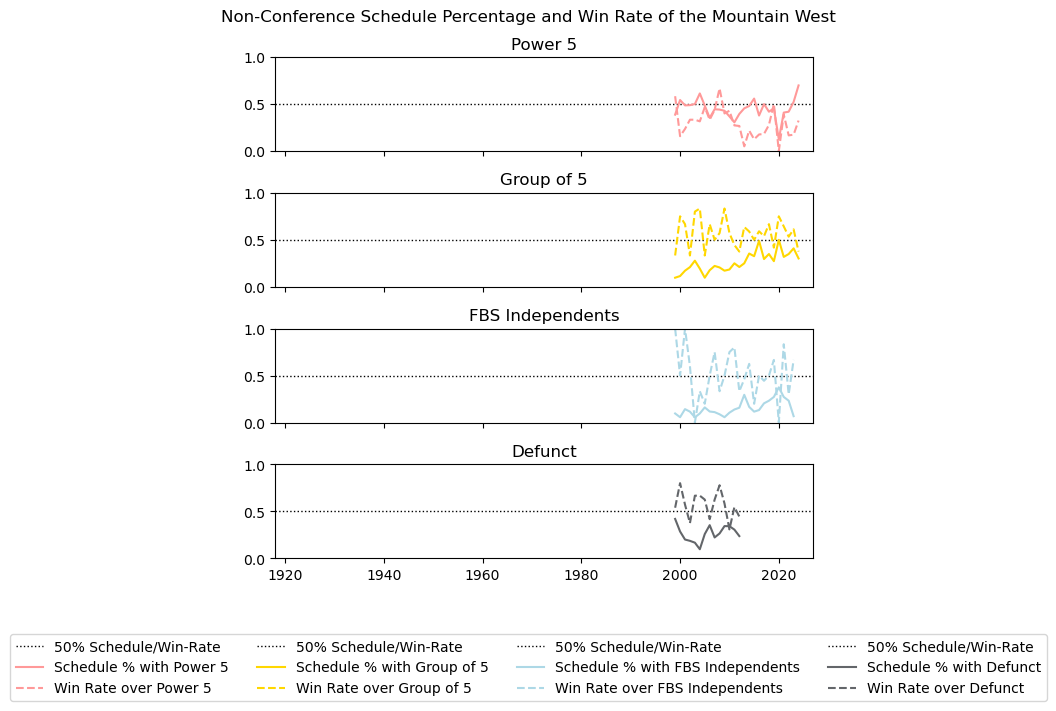

In [68]:
conference = 'Mountain West'
print_conference_schedule_performance(conference, fbs_non_conference_record_with_schedule)

#### Key Takeaways:
1. Mountain West has not done well against Power 5. They are playing them less and losing more.
2. Mountain West has won an estimated 40-60 percent of its games against the Group of 5.
3. As Mountain West is scheduling more Group of 5 games, it win-rate against them has remained about the same (40-60%).
4. Mountain West has played about the same amount of Power 5 opponents as non-Power 5.

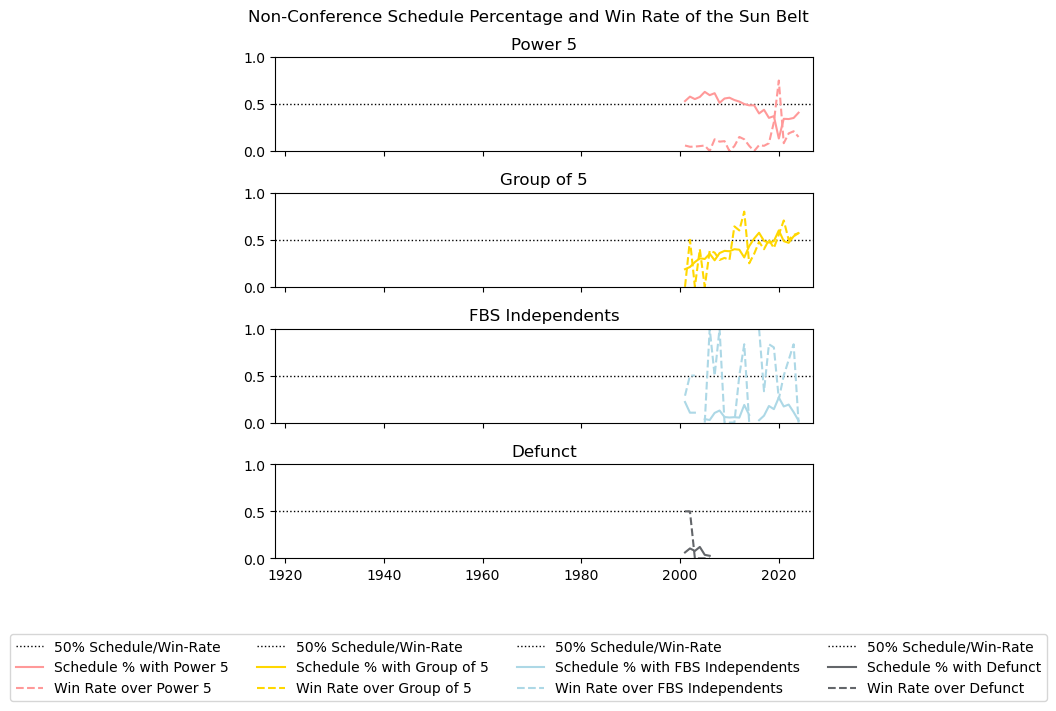

In [69]:
conference = 'Sun Belt'
print_conference_schedule_performance(conference, fbs_non_conference_record_with_schedule)

#### Key Takeaways:
1. Sun Belt has not done well against Power 5. They are playing them less but seem to be winning more.
2. Sun Belt is a rising star within the Group of 5 by playing them more and winning more.

### 3.5.2 - How often do conferences play each other and what are the outcomes?

Findings General:
1. There is a strong SEC and ACC schedule relationship (~50% of Power 5 schedule)
2. There seems to be a strong Big Ten and Big 12 and PAC-12 schedule relationship (~50% of Power 5 schedule)
3. There does not seem to be similarly obvious relationships in the Group of 5. (Maybe their comparatively young age has not allowed the relationships to show through in the data)

Power 5
- ACC
  1. ACC typically loses to Power 5 teams
  2. The greatest negative impact to their Power 5 win rate has been their long match-up with the SEC. They schedule them frequently and win at a lower rate against them than against other Power 5 conferences.
  3. ACC has seen consistent success against Group of 5 Conferences.

- Big Ten
  1. Big Ten's worst win rate is against the SEC where they win about 40% of the time.
  2. Except for the Pac 12 and SEC, Big Ten typically wins its non-conference games.
  2. Big Ten's elevated win rates typically come from Group of 5 opponents

- Big 12
  1. Big 12 wins against ACC and Pac-12 opponents just over 50% of the time.
  2. Big 12 wins against SEC and Big Ten opponents around 40% of the time.

- Pac-12
  1. Pac-12 frequently plays Big Ten and Big 12 and has about a 50% win rate against them (maybe less)
  2. Pac-12 does moderately well against the ACC
  3. Pac-12 has about a 40% win rate against the SEC
  4. Pac-12 does not play many Group of 5 opponents except Mountain West.

- SEC
  1. SEC typically play ACC
  2. SEC typically wins 60% of the time against its Power 5 opponents
  3. Although SEC typically beats group of 5 teams over 70% of the time, they have only beat American Athletic about 60% of the time
  4. The biggest boost to SEC's win rate has been its frequency of playing with ACC. SEC has an estimated 65% win rate while scheduling twice as much as other conferences.

Group of 5:
- American Athletic
  1. ACC plays with American Athletic almost twice as much as the other Power 5 conferences play American Athletic.
  2. With the exception of Mountain West, American Athletic has beat Group of 5 teams about 70% of the time

- Conference USA
  1. Conference USA has a more even distribution of its schedule amount all conferences.

- Mid-American
  1. Mid American typically plays with Big Ten and only wins games around 15% of the time.
  2. Against Big 12 opponents, Mid American has almost double the win rate compared to other Power 5 conferences (but still <50%)

- Mountain West
  1. Mountain West plays Pac 12 about twice as much as other Power 5 conferences.
  2. Mountain West wins about 45% of its games against the ACC (best performance vs Power 5 opponents)

- Sun Belt
  1. Sun Belt plays SEC the most out of the Power 5
  2. Sun Belt plays Conference USA the most out of the Group of 5.
  3. Sun Belt has seen ralative success against Mid American ad Conference USA opponents.

Independents
  1. Independents have typically had a 50% win rate or less
  2. Independents have an estimated 35% win rate against the SEC (worst of all conferences)

#### 3.5.2.1 - Find the number of times the conferences have played each other.

In [70]:
# Import seaborn library
import seaborn as sns
 
# Declaring the cm variable by the 
# color palette from seaborn
cm = sns.light_palette("blue", as_cmap=True)

current_conferences = ['ACC', 'Big Ten', 'Big 12', 'Pac-12', 'SEC','American Athletic', 'Conference USA', 'Mid-American', 'Mountain West', 'Sun Belt', 'FBS Independents']
to_plot = fbs_non_conference[fbs_non_conference['homeConference'].isin(current_conferences) &
                             fbs_non_conference['awayConference'].isin(current_conferences)]

conference_matchups_part_1 = to_plot[['homeConference', 'awayConference', 'id']].pivot_table(index = 'homeConference', columns = 'awayConference', aggfunc = 'count')
conference_matchups_part_2 = to_plot[['homeConference', 'awayConference', 'id']].pivot_table(index = 'awayConference', columns = 'homeConference', aggfunc = 'count')
conference_matchups_overall = conference_matchups_part_1+conference_matchups_part_2
# Visualizing the DataFrame with set precision
conference_matchups_overall.style.background_gradient(cmap=cm).set_precision(2)


#### Key Takeaways
1. There is a strong SEC and ACC relationship:
   - SEC has played almost half of its Power 5 non-conference games against ACC.
   - ACC has played over half of its Power 5 non-conference games against the SEC
2. There seems to be a strong Big Ten and Big 12 and PAC-12 relationship
   - Big Ten plays over half its Power 5 non-conference games with Big 12 or Pac-12
   - Big 12 plays over half its Power 5 non-conference games with Big Ten or Pac-12
   - Pac 12 plays ~80% its Power 5 non-conference games with Big Ten or Big 12
3. There does not seem to be similarly obvious relationships in the Group of 5. (Maybe their comparatively young age has not allowed the relationships to show through in the data)

#### 3.5.2.2 - Find the overall win-rate of one conference against another

In [71]:
current_conferences = ['ACC', 'Big Ten', 'Big 12', 'Pac-12', 'SEC','American Athletic', 'Conference USA', 'Mid-American', 'Mountain West', 'Sun Belt', 'FBS Independents']

fbs_non_conference_0 = fbs_non_conference[['season', 'week', 'homeId', 'homeTeam', 'homeConference', 'homeOutcome', 'awayId', 'awayTeam', 'awayConference']]
fbs_non_conference_1 = fbs_non_conference[['season', 'week', 'awayId', 'awayTeam', 'awayConference', 'awayOutcome', 'homeId', 'homeTeam', 'homeConference']]

fbs_non_conference_0.rename({'homeID': 'schoolId_1',
                             'homeTeam': 'team_1',
                             'homeConference': 'conference_source',
                             'awayID': 'schoolId_2',
                             'awayTeam': 'team_2',
                             'awayConference': 'conference_opponent',
                             'homeOutcome': 'win-rate'}, inplace = True, axis = 'columns')

fbs_non_conference_1.rename({'homeID': 'schoolId_2',
                             'homeTeam': 'team_2',
                             'homeConference': 'conference_opponent',
                             'awayID': 'schoolId_1',
                             'awayTeam': 'team_1',
                             'awayConference': 'conference_source',
                             'awayOutcome': 'win-rate'}, inplace = True, axis = 'columns')

fbs_non_conference_by_school_for_overall = pd.concat([fbs_non_conference_0, fbs_non_conference_1])

fbs_non_conference_by_school_for_overall = fbs_non_conference_by_school_for_overall.replace({'win-rate': {'Win': 1, 'Loss':0, 'Tie':0.5}})

to_plot = fbs_non_conference_by_school_for_overall[fbs_non_conference_by_school_for_overall['conference_source'].isin(current_conferences) &
                                                   fbs_non_conference_by_school_for_overall['conference_opponent'].isin(current_conferences)]

#find the average win percentage of each conference
fbs_non_conference_record_overall = to_plot.groupby(['conference_source', 'conference_opponent'])['win-rate'].mean().reset_index()


#### 3.5.2.3 - Create a helper function for printing a conference's win-rate and schedule-rate against others

In [72]:
def print_overall_conference_schedule_win_rate(conference, conference_matchups_overall, fbs_non_conference_record_overall):
    
    conf_overall_win_rates = fbs_non_conference_record_overall[fbs_non_conference_record_overall['conference_source']==conference]

    conf_schedule_rate_overall = conference_matchups_overall.copy()

    conf_schedule_rate_overall.columns = [col[1] for col in conf_schedule_rate_overall.columns.to_flat_index()]
    conf_schedule_rate_overall['schedule-rate'] = conf_schedule_rate_overall[conference]/conf_schedule_rate_overall[conference].sum()
    conf_schedule_rate_overall.reset_index(inplace = True)

    conf_schedule_rate_overall = conf_schedule_rate_overall[conf_schedule_rate_overall['homeConference']!=conference]

    combined = conf_schedule_rate_overall.reset_index()
    combined = combined.merge(conf_overall_win_rates, how = 'inner', left_on = 'homeConference', right_on = 'conference_opponent')

    plot_data = combined[['conference_opponent', 'win-rate', 'schedule-rate']].set_index('conference_opponent')
    plot_data.plot(kind='barh', title = f'Overall Schedule/Win Rate of the {conference} Conference')

    # plot vertical line of the 50% win rate
    plt.vlines(0.5, ymin = -1, ymax = 10, colors='black', linestyles='dotted', label='50% Win-Rate')

    plt.xlim([0,1])

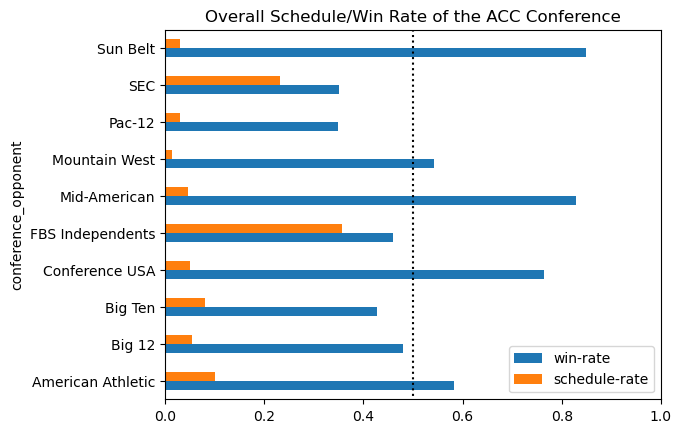

In [73]:
conference = 'ACC'
print_overall_conference_schedule_win_rate(conference, conference_matchups_overall, fbs_non_conference_record_overall)


#### Key Takeaways:
1. ACC typically loses to Power 5 teams
2. The greatest negative impact to their Power 5 win rate has been their long match-up with the SEC. They schedule them frequently and win at a lower rate against them than against other Power 5 conferences.
3. ACC has seen consistent success against Group of 5 Conferences.

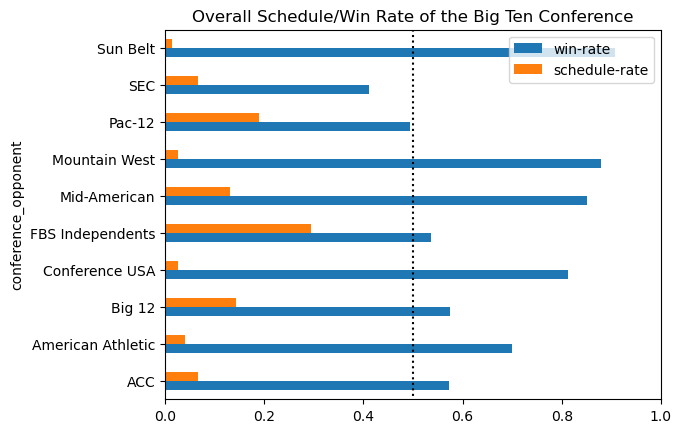

In [74]:
conference = 'Big Ten'
print_overall_conference_schedule_win_rate(conference, conference_matchups_overall, fbs_non_conference_record_overall)

#### Key Takeaways:
1. Big Ten's worst win rate is against the SEC where they win about 40% of the time.
2. Except for the Pac 12 and SEC, Big Ten typically wins its non-conference games.
2. Big Ten's elevated win rates typically come from Group of 5 opponents

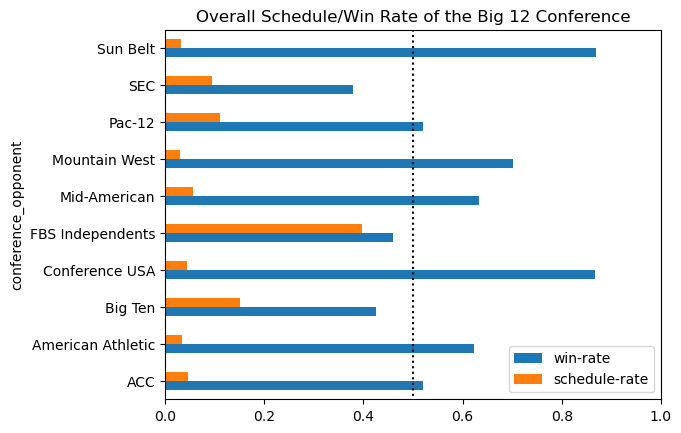

In [75]:
conference = 'Big 12'
print_overall_conference_schedule_win_rate(conference, conference_matchups_overall, fbs_non_conference_record_overall)

#### Key Takeaways:
1. Big 12 wins against ACC and Pac-12 opponents just over 50% of the time.
2. Big 12 wins against SEC and Big Ten opponents around 40% of the time.

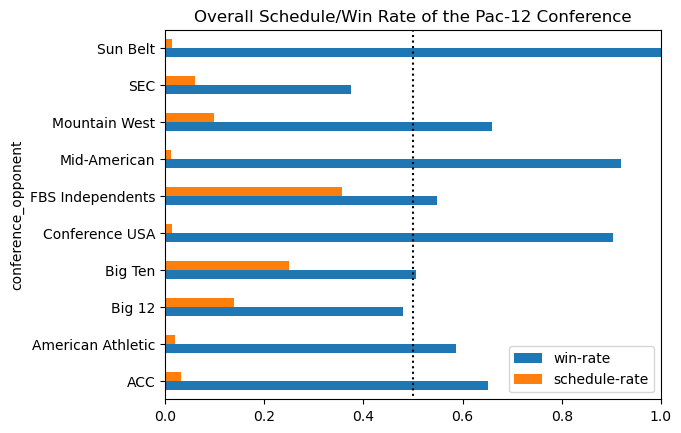

In [76]:
conference = 'Pac-12'
print_overall_conference_schedule_win_rate(conference, conference_matchups_overall, fbs_non_conference_record_overall)

#### Key Takeaways:
1. Pac-12 frequently plays Big Ten and Big 12 and has about a 50% win rate against them (maybe less)
2. Pac-12 does moderately well against the ACC
3. Pac-12 has about a 40% win rate against the SEC
4. Pac-12 does not play many Group of 5 opponents except Mountain West.

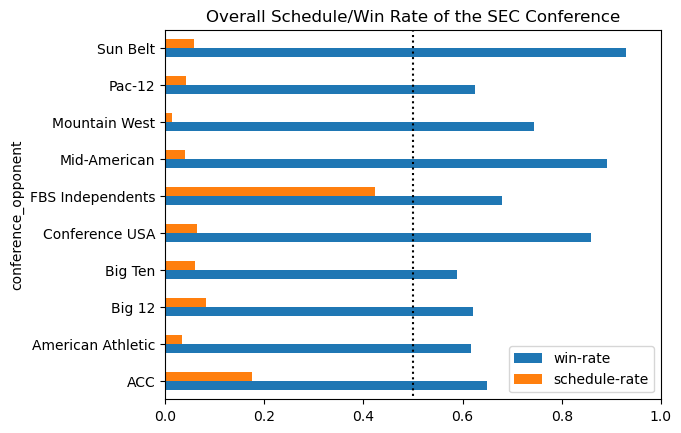

In [77]:
conference = 'SEC'
print_overall_conference_schedule_win_rate(conference, conference_matchups_overall, fbs_non_conference_record_overall)

#### Key Takeaways:
1. SEC typically play ACC
2. SEC typically wins 60% of the time against its Power 5 opponents
3. Although SEC typically beats group of 5 teams over 70% of the time, they have only beat American Athletic about 60% of the time
4. The biggest boost to SEC's win rate has been its frequency of playing with ACC. SEC has an estimated 65% win rate while scheduling twice as much as other conferences.

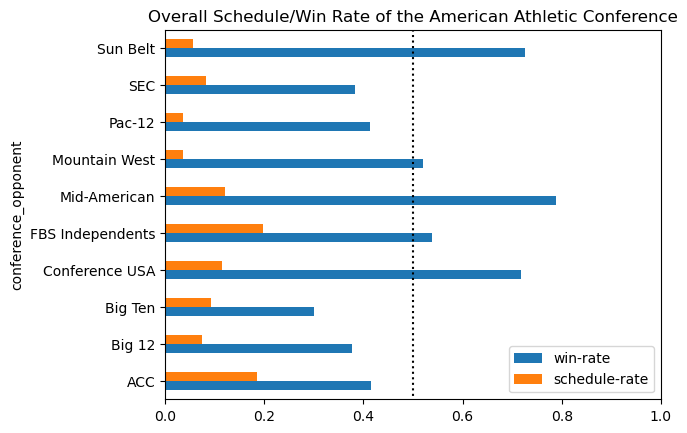

In [78]:
conference = 'American Athletic'
print_overall_conference_schedule_win_rate(conference, conference_matchups_overall, fbs_non_conference_record_overall)

#### Key Takeaways:
1. ACC plays with American Athletic almost twice as much as the other Power 5 conferences play American Athletic.
2. With the exception of Mountain West, American Athletic has beat Group of 5 teams about 70% of the time

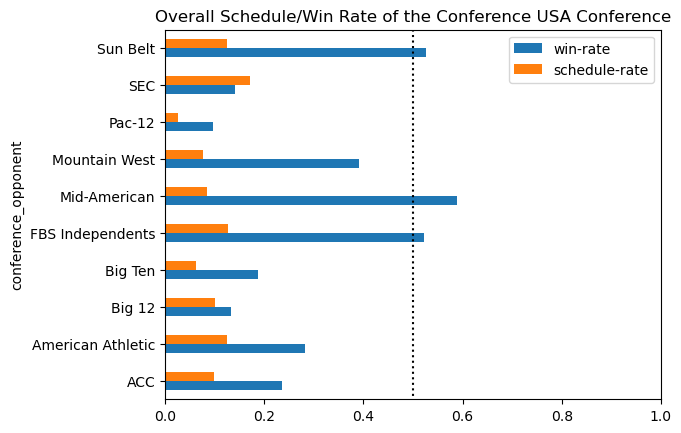

In [79]:
conference = 'Conference USA'
print_overall_conference_schedule_win_rate(conference, conference_matchups_overall, fbs_non_conference_record_overall)

#### Key Takeaways:
1. Conference USA has a more even distribution of its schedule amount all conferences.

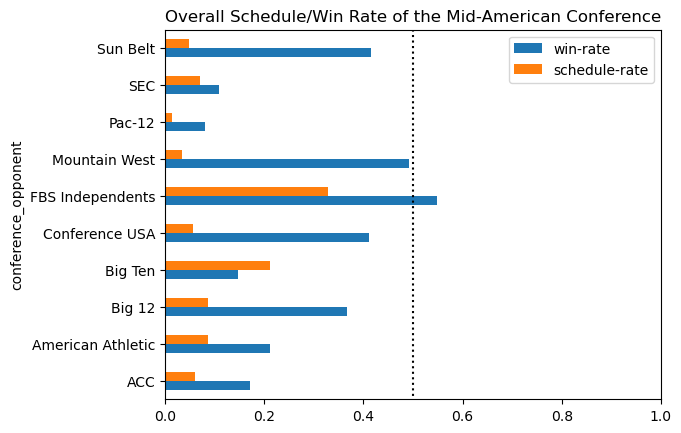

In [80]:
conference = 'Mid-American'
print_overall_conference_schedule_win_rate(conference, conference_matchups_overall, fbs_non_conference_record_overall)

#### Key Takeaways:
1. Mid American typically plays with Big Ten and only wins games around 15% of the time.
2. Against Big 12 opponents, Mid American has almost double the win rate compared to other Power 5 conferences (but still <50%)

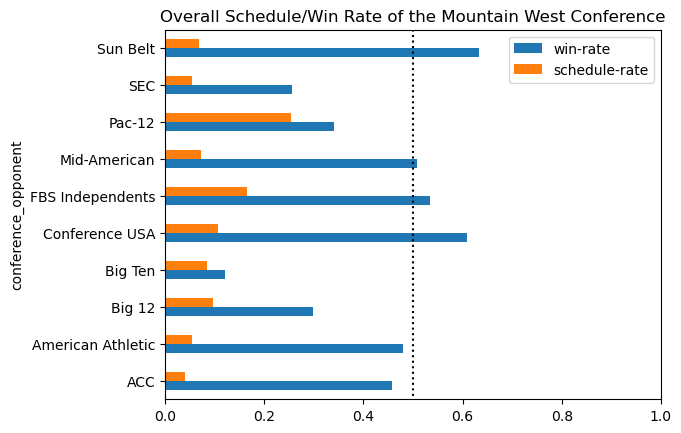

In [81]:
conference = 'Mountain West'
print_overall_conference_schedule_win_rate(conference, conference_matchups_overall, fbs_non_conference_record_overall)

#### Key Takeaways:
1. Mountain West plays Pac 12 about twice as much as other Power 5 conferences.
2. Mountain West wins about 45% of its games against the ACC (best performance vs Power 5 opponents)

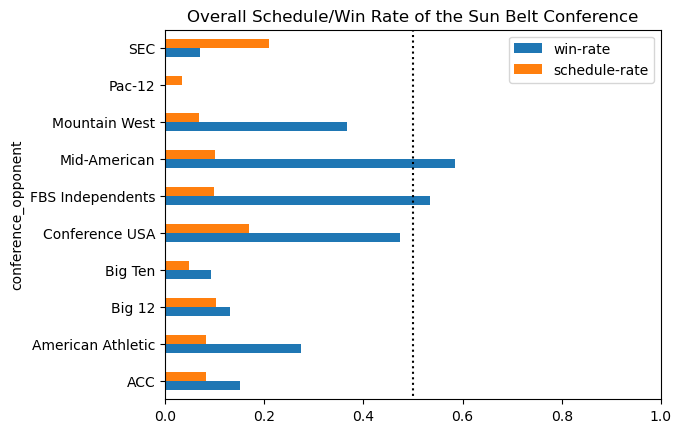

In [82]:
conference = 'Sun Belt'
print_overall_conference_schedule_win_rate(conference, conference_matchups_overall, fbs_non_conference_record_overall)

#### Key Takeaways:
1. Sun Belt plays SEC the most out of the Power 5
2. Sun Belt plays Conference USA the most out of the Group of 5.
3. Sun Belt has seen relative success against Mid American ad Conference USA opponents.

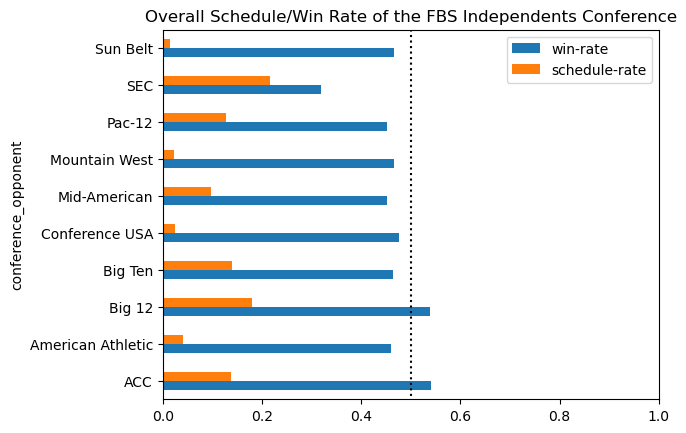

In [83]:
conference = 'FBS Independents'
print_overall_conference_schedule_win_rate(conference, conference_matchups_overall, fbs_non_conference_record_overall)

#### Key Takeaways:
1. Independents have typically had a 50% win rate or less
2. Independents have an estimated 35% win rate against the SEC (worst of all conferences)

# Future Analysis
   1. Is there a correlation between program funding and program performance? Some of that data may not be accessible or readily available. The head coach salary might be a good proxy, but there could be issues with that as well. Another proxy might be the number of bowl games.
   2. The spread of win-loss percentages in the conference. ie. Are all teams of equal strength or do only a few stand out year to year?
   3. Take the current teams that are in the conferences now and recalculate the non-conference win percentages as if that was the conference 100 years ago. More of a team-group strength approach. A side project of this would be answering the "Dream Conference" question "What would the best team group of size X be if they were in the same conference for the last 100 years?"